# Imports

Importing the rewritten library of the model from github and the dataset

In [1]:
!rm -rf /kaggle/working/GMNER

In [2]:
!git clone https://github.com/GiuseppeFrigeni/GMNER.git

Cloning into 'GMNER'...
remote: Enumerating objects: 6126, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 6126 (delta 27), reused 12 (delta 6), pack-reused 6067 (from 2)
Receiving objects: 100% (6126/6126), 1.80 MiB | 18.59 MiB/s, done.
Resolving deltas: 100% (5882/5882), done.


In [3]:
#to download VinVL features
!gdown https://drive.google.com/uc?id=1D6ybnUuGVGF3g6Zr_Jp8JEtO-8klSBNv
!unzip -q /kaggle/working/Twitter10000_VinVL.zip
!rm -rf /kaggle/working/Twitter10000_VinVL.zip

In [1]:
#to donwload the images
!gdown https://drive.google.com/uc?id=1PpvvncnQkgDNeBMKVgG2zFYuRhbL873g
!unzip -q /kaggle/working/IJCAI2019_data.zip
!rm -rf /kaggle/working/IJCAI2019_data.zip

Downloading...
From (original): https://drive.google.com/uc?id=1PpvvncnQkgDNeBMKVgG2zFYuRhbL873g
From (redirected): https://drive.google.com/uc?id=1PpvvncnQkgDNeBMKVgG2zFYuRhbL873g&confirm=t&uuid=e373903e-6ee1-46db-bb5d-5e983387d601
To: /kaggle/working/IJCAI2019_data.zip
100%|███████████████████████████████████████| 1.03G/1.03G [00:06<00:00, 153MB/s]


In [1]:
import sys
import os

import warnings

warnings.filterwarnings('ignore')

import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from itertools import chain

from safetensors.torch import load_model, save_model

from GMNER.model.data_pipe import BartNERPipe
from GMNER.model.bart_multi_concat import BartSeq2SeqModel
from GMNER.model.generater_multi_concat import SequenceGeneratorModel
from GMNER.model.metrics import Seq2SeqSpanMetric
from GMNER.model.losses import get_loss

from torch import optim
from tqdm import tqdm
from GMNER.model.utils import _move_dict_value_to_device



2025-06-10 10:14:06.312410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749550446.499871      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749550446.553639      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Globals

In [2]:
bart_name = 'facebook/bart-base'
datapath = '/kaggle/working/GMNER/Twitter10000_v2.0/txt'
image_annotation_path = '/kaggle/working/GMNER/Twitter10000_v2.0/xml'

#Change path depending if dataset is in use or if donwloaded
image_feature_path = '/kaggle/working/Twitter10000_VinVL' #downloaded
#image_feature_path = '/kaggle/input/twitter10000-vinvl/Twitter10000_VinVL' #kaggle uploaded dataset


region_loss_ratio = 1.0
box_num = 16
normalize = True
use_kl = True

lr = 3e-5
n_epochs = 30
max_len = 30
batch_size = 32
seed = 42
save_model_ = True
save_path = '/kaggle/working//best_model.safetensors'
log = '/kaggle/working//logs'

dataset_name = 'twitter-ner'
length_penalty = 1
target_type = 'word'
decoder_type = 'avg_feature'
num_beams = 1
use_encoder_mlp = True
pred_output_file = '/kaggle/working//output_file'

if 'twitter' in dataset_name:
    max_len, max_len_a = max_len, 0.6
else:
    print("Error dataset_name!")

In [3]:
if isinstance(decoder_type, str) and decoder_type.lower() == 'none':
    decoder_type = None
demo = False

# Data

In [4]:
def get_data():

    pipe = BartNERPipe(image_feature_path=image_feature_path,
                       image_annotation_path=image_annotation_path,
                       max_bbox =box_num,
                       normalize=normalize,
                       tokenizer=bart_name,
                       target_type=target_type)
    if dataset_name == 'twitter-ner':
        paths ={
            'train': os.path.join(datapath,'train.txt'),
            'dev': os.path.join(datapath,'dev.txt'),
            'test': os.path.join(datapath,'test.txt') }
        data_bundle = pipe.process_from_file(paths, demo=demo)

    return data_bundle, pipe.tokenizer, pipe.mapping2id

data_bundle, tokenizer, mapping2id = get_data()

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The number of samples: 7000
The number of samples: 1500
The number of samples: 1500
num_added_tokens: 6
not_cover: 1947


In [5]:
print(f'max_len_a:{max_len_a}, max_len:{max_len}')

print("The number of tokens in tokenizer ", tokenizer.vocab_size)

max_len_a:0.6, max_len:30
The number of tokens in tokenizer  50265


In [6]:
bos_token_id = 0
eos_token_id = 1
label_ids = list(mapping2id.values())

In [7]:
train_dataset = data_bundle.get_dataset('train')
eval_dataset = data_bundle.get_dataset('dev')
test_dataset = data_bundle.get_dataset('test')
print(train_dataset[:3])

+--------+---------------+--------------+-----------------+------------------+----------------+-------------------+----------------+-----------------+----------------+-----------+-----------+-------------------+------------------+----------------+-------------+-------------+
| img_id | raw_words     | entities     | entity_tags     | entity_spans     | raw_target     | coarse_target     | tgt_tokens     | target_span     | src_tokens     | first     | image_tag | image_feature     | region_label     | cover_flag     | src_seq_len | tgt_seq_len |
+--------+---------------+--------------+-----------------+------------------+----------------+-------------------+----------------+-----------------+----------------+-----------+-----------+-------------------+------------------+----------------+-------------+-------------+
| 797970 | ['RT', '@'... | [['Pak']]... | ['loc']         | [[5, 5]]         | ['O', 'O', ... | ['O', 'O', 'O'... | [0, 17, 3, ... | [[17, 3, 4]]... | [0, 10541, ... | [0, 

In [8]:
def create_collate_fn(tensor_fields, padding_values_map):
    """
    Creates a custom collate function for a batch of Instance objects.
    - Fields specified in `tensor_fields` will be converted to tensors.
    - If these tensorized fields are sequences of varying lengths, they will be padded
      using values from `padding_values_map`.
    - Other fields will be returned as lists.

    Args:
        tensor_fields: A list of the field namesfrom the Instance objects that should be converted to tensors.
        padding_values_map: A dictionary mapping field names to their respective padding values. This is used forfields that are tensorized and found to be variable-length sequences.
    Returns:
        function: The collate function.
    """
    if not isinstance(padding_values_map, dict):
        raise ValueError("padding_values_map must be a dictionary.")

    def collate_fn(batch):
        if not batch:
            return {}

        first_instance_fields = batch[0].fields # Assuming consistent field names
        collated_batch = {}

        for field_name in first_instance_fields.keys():
            values_for_field = [instance[field_name] for instance in batch]

            if field_name in tensor_fields:
                try:
                    # Convert all items for this field to tensors
                    tensor_items = [torch.as_tensor(item) for item in values_for_field]

                    # Check if items need padding or can be simply stacked
                    if not tensor_items: # Should not happen if batch is not empty
                        collated_batch[field_name] = torch.empty(0)
                        continue

                    first_item_ndim = tensor_items[0].ndim

                    if first_item_ndim == 0: # All items are scalar tensors
                        collated_batch[field_name] = torch.stack(tensor_items)
                    else: # Items are non-scalar (sequences or multi-dimensional)
                        # Check if all tensors have the exact same shape
                        is_same_shape = True
                        first_shape = tensor_items[0].shape
                        for t in tensor_items[1:]:
                            if t.shape != first_shape:
                                is_same_shape = False
                                break

                        if is_same_shape:
                            # All tensors have the same shape, stack them
                            collated_batch[field_name] = torch.stack(tensor_items)
                        else:
                            # Shapes differ, requires padding.
                            # This typically applies to sequences (1D tensors of varying lengths)
                            # or lists of multi-D tensors where the first dimension varies (e.g. region_label)
                            padding_value = padding_values_map.get(field_name)
                            if padding_value is None:
                                print(f"Warning: No padding value specified in padding_values_map for variable-length field '{field_name}'. Defaulting to 0.")
                                padding_value = 0

                            collated_batch[field_name] = pad_sequence(
                                tensor_items, batch_first=True, padding_value=float(padding_value) # pad_sequence expects float for padding_value
                            )
                except Exception as e:
                    print(f"Error collating field '{field_name}': {e}. Returning as list.")
                    collated_batch[field_name] = values_for_field # Fallback to list
            else:
                # Field not in tensor_fields_map, return as a list
                collated_batch[field_name] = values_for_field

        return collated_batch

    return collate_fn


In [9]:
tensor_fields = ['src_tokens', 'image_feature', 'tgt_tokens', 'src_seq_len', 'tgt_seq_len', 'first', 'region_label']

padding_values = {
    'src_tokens': tokenizer.pad_token_id,
    'tgt_tokens': tokenizer.pad_token_id, 
    'first': 0,                          
    'region_label': -100,                
    # 'image_feature' is pre-padded in BartNERPipe, so it won't hit the pad_sequence path.
    # 'src_seq_len', 'tgt_seq_len' are scalars, they will be stacked.
}

collate_fn = create_collate_fn(
    tensor_fields=tensor_fields,
    padding_values_map=padding_values
)


In [10]:
train_dataset[2]['raw_words']

['Nick',
 'Jonas',
 'feared',
 'pal',
 'Demi',
 'Lovato',
 'would',
 'suffer',
 'drug',
 'death']

In [11]:
torch.tensor(train_dataset[2]['region_label'])

tensor([[0.5659, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.4341, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3620, 0.0000, 0.0000, 0.6380,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)

In [12]:
train_dataset[2]['tgt_tokens']

[0, 9, 10, 2, 5, 13, 15, 2, 5, 1]

In [13]:
img_id = train_dataset[2]['img_id']
img_id

'O_3437'

In [14]:
train_dataset[2]['image_feature'].shape

(16, 2048)

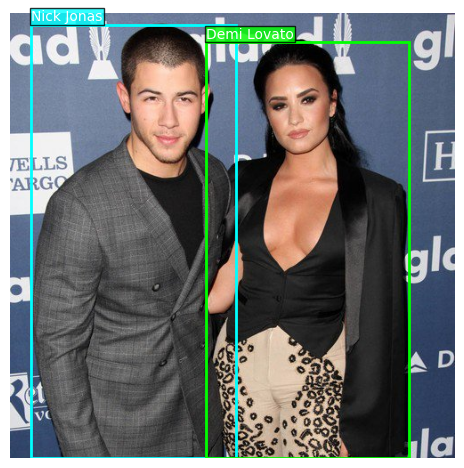

In [15]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

root = ET.parse("/kaggle/working/GMNER/Twitter10000_v2.0/xml/"+ img_id + ".xml").getroot()

img = Image.open("/kaggle/working/IJCAI2019_data/twitter2017_images/" + img_id + ".jpg") 


def plot_image(img, root):
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    colors = ['cyan', 'lime', 'yellow', 'magenta']

    for i, obj in enumerate(root.findall('object')):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
    
        # Get coordinates and convert them to integers
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
    
        # Calculate width and height of the bounding box
        box_width = xmax - xmin
        box_height = ymax - ymin
    
        # Choose a color for the box
        box_color = colors[i % len(colors)]
    
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (xmin, ymin), 
            box_width, 
            box_height, 
            linewidth=2, 
            edgecolor=box_color, 
            facecolor='none'
        )
    
        # Add the rectangle to the Axes
        ax.add_patch(rect)
    
        # Add the label (object name)
        ax.text(
            xmin, 
            ymin - 5, # Position the text slightly above the box
            name, 
            color='white', 
            fontsize=10,
            bbox=dict(facecolor=box_color, alpha=0.8, pad=1)
        )

    plt.axis('off') # Hide the axes
    plt.tight_layout()
    plt.show()

plot_image(img, root)

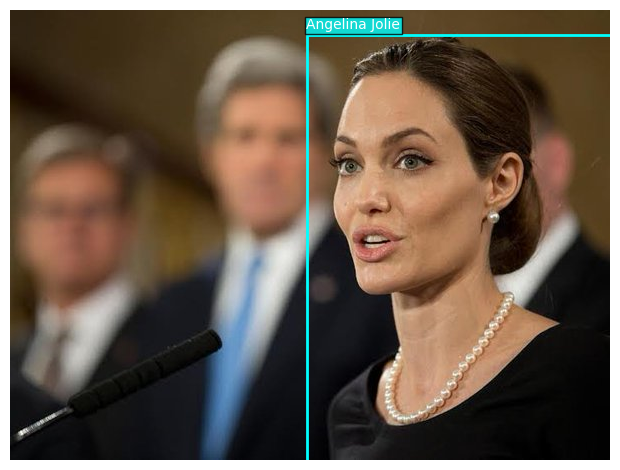

In [16]:
test_img_id = test_dataset[2]['img_id']

root = ET.parse("/kaggle/working/GMNER/Twitter10000_v2.0/xml/"+ test_img_id + ".xml").getroot()

img = Image.open("/kaggle/working/IJCAI2019_data/twitter2017_images/" + test_img_id + ".jpg")

plot_image(img, root)

# Utils

In [17]:
def Training(train_idx, train_data, model, device, optimizer,batch_size=batch_size, use_kl=use_kl,region_loss_ratio=region_loss_ratio, text_only=False, only_text=False):
    """
        Modified Training function for text-only ablation.

    Args:
        train_idx (int): Current epoch index.
        train_data (Dataset): The training dataset.
        model : The model to train.
        device (torch.device): The device to train on (e.g., 'cuda', 'cpu').
        optimizer (torch.optim.Optimizer): The optimizer.
        collate_fn (callable): The collate function for the DataLoader.
        text_only (bool): If True, image features are zeroed out.
    Returns:
        train_loss (int): Sum of all the tokens losses in the epoch
        train_region_loss (int): Sum of all the region losses in the epoch
    """

    train_data_iterator = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    if text_only or only_text:
        region_loss_ratio = 0.


    train_loss = 0.
    train_region_loss = 0.

    for batch_idx, batch_x in enumerate(tqdm(train_data_iterator, desc=f"Epoch {train_idx} Training")):
        _move_dict_value_to_device(batch_x, device=device)
        src_tokens = batch_x['src_tokens']
        image_feature = batch_x['image_feature']
        tgt_tokens = batch_x['tgt_tokens']
        src_seq_len = batch_x['src_seq_len']
        tgt_seq_len = batch_x['tgt_seq_len']
        first = batch_x['first']
        region_label = batch_x['region_label']

        if text_only or only_text:
            image_feature = torch.zeros_like(image_feature, device=device)

        pred, region_pred = model(src_tokens,image_feature, tgt_tokens, src_seq_len=src_seq_len, tgt_seq_len=tgt_seq_len, first=first, text_only=text_only)


        loss, region_loss = get_loss(tgt_tokens, tgt_seq_len, pred, region_pred,region_label,use_kl=use_kl)


        train_loss += loss.item()
        train_region_loss += region_loss.item()
        all_loss = loss + region_loss_ratio * region_loss

        optimizer.zero_grad()
        all_loss.backward()
        optimizer.step()



    print("train_loss: %f"%(train_loss))
    print("train_region_loss: %f"%(train_region_loss))
    return train_loss, train_region_loss

In [18]:
def Inference(eval_data, model, device, metric,batch_size=batch_size, text_only=False, only_text=False):
    """
    Modified Training function for text-only ablation.

    Args:
        train_idx (int): Current epoch index.
        train_data (Dataset): The training dataset.
        model : The model to train.
        device (torch.device): The device to train on (e.g., 'cuda', 'cpu').
        optimizer (torch.optim.Optimizer): The optimizer.
        collate_fn (callable): The collate function for the DataLoader.
        text_only_ablation (bool): If True, image features are zeroed out.
    Returns:
        res (dict): Dictionary with all the metrics
    """
    
    data_iterator = torch.utils.data.DataLoader(dataset=eval_data, batch_size=batch_size * 2, shuffle=False, collate_fn=collate_fn)

    for batch_x in tqdm(data_iterator,desc=f"Inference"):

        _move_dict_value_to_device(batch_x, device=device)
        src_tokens = batch_x['src_tokens']
        image_feature = batch_x['image_feature']
        tgt_tokens = batch_x['tgt_tokens']
        src_seq_len = batch_x['src_seq_len']
        tgt_seq_len = batch_x['tgt_seq_len']
        first = batch_x['first']
        region_label = batch_x['region_label']
        target_span = batch_x['target_span']
        cover_flag = batch_x['cover_flag']

        if text_only or only_text:
            image_feature = torch.zeros_like(image_feature, device=device)

        pred, region_pred = model.predict(src_tokens,image_feature, src_seq_len=src_seq_len, first=first, text_only=text_only)

        metric.evaluate(target_span, pred, tgt_tokens, region_pred,region_label,cover_flag)
    res = metric.get_metric()  ## {'f': 20.0, 'rec': 16.39, 'pre': 25.64, 'em': 0.125, 'uc': 0}
    return res

In [19]:
import matplotlib.pyplot as plt
import random

def plot_losses_and_metrics(loss1, loss2, metrics_list, 
                            loss1_label='Loss', loss2_label='Region Loss', 
                            figsize=(14, 6)):
    """
    Plots two loss curves and multiple metric curves in two side-by-side subplots.

    Args:
        loss1 (list): A list of numerical values for the first loss.
        loss2 (list): A list of numerical values for the second loss.
        metrics_list (list of dict): A list where each element is a dictionary 
                                     of metrics for that epoch. 
                                     e.g., [{'acc': 0.9, 'f1': 0.8}, {'acc': 0.91, 'f1': 0.82}]
        loss1_label (str): The label for the first loss curve.
        loss2_label (str): The label for the second loss curve.
        figsize (tuple): The size of the entire figure.
    """
    if not metrics_list:
        print("Metrics list is empty. Cannot plot metrics.")
        return

    # 1 row, 2 columns for side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # --- Plot 1: Losses ---
    epochs_loss = range(1, len(loss1) + 1)
    ax1.plot(epochs_loss, loss1, 'o-', label=loss1_label)
    ax1.plot(epochs_loss, loss2, 'o-', label=loss2_label)
    ax1.set_title('Train & Region Losses')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    # --- Plot 2: Metrics ---
    # Get the names of the metrics from the first dictionary
    metric_names = list(metrics_list[0].keys())[:3]
    epochs_metrics = range(1, len(metrics_list) + 1)

    for metric_name in metric_names:
        # Extract the values for the current metric from the list of dictionaries
        metric_values = [epoch_metrics[metric_name] for epoch_metrics in metrics_list]
        ax2.plot(epochs_metrics, metric_values, 'o-', label=metric_name.replace('_', ' ').title())
    
    ax2.set_title('Performance Metrics')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Value')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    # --- Display the Plots ---
    plt.tight_layout()
    plt.show()


# Network

In [30]:
model = BartSeq2SeqModel.build_model(bart_name, tokenizer, label_ids=label_ids, decoder_type=decoder_type,
                                     use_encoder_mlp=use_encoder_mlp,box_num = box_num)

model = SequenceGeneratorModel(model, bos_token_id=bos_token_id,
                               eos_token_id=eos_token_id,
                               max_length=max_len, max_len_a=max_len_a,num_beams=num_beams, do_sample=False,
                               repetition_penalty=1, length_penalty=length_penalty, pad_token_id=eos_token_id,
                               restricter=None, top_k = 1
                               )

Some weights of BartModel were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['encoder.img_proj.bias', 'encoder.img_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
#testing model works
batch = collate_fn([train_dataset[2]]) 

src_tokens = batch['src_tokens']
image_feature = batch['image_feature']
tgt_tokens = batch['tgt_tokens']
src_seq_len = batch['src_seq_len']
tgt_seq_len = batch['tgt_seq_len']
first = batch['first']
region_label = batch['region_label']

pred, region_pred = model(src_tokens,image_feature, tgt_tokens, src_seq_len=src_seq_len, tgt_seq_len=tgt_seq_len, first=first)
pred.shape, tgt_tokens.shape

(torch.Size([1, 9, 22]), torch.Size([1, 10]))

In [22]:
tgt_tokens, torch.argmax(torch.nn.functional.softmax(pred, dim=1), dim=2)

(tensor([[ 0,  9, 10,  2,  5, 13, 15,  2,  5,  1]]),
 tensor([[ 1,  9, 13, 18, 20, 14, 16,  5, 15]]))

In [23]:
## parameter scale
total = sum([param.nelement() for param in model.parameters()])
print("Number of parameter: %.2fM" % (total/1e6))
##

Number of parameter: 142.79M


In [31]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(device)

device = torch.device(device)
model.to(device)

cuda


SequenceGeneratorModel(
  (seq2seq_model): BartSeq2SeqModel(
    (encoder): FBartEncoder(
      (bart_encoder): BartEncoder(
        (embed_tokens): Embedding(50276, 768, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(1026, 768, padding_idx=1)
        (img_proj): Linear(in_features=2048, out_features=768, bias=True)
        (layers): ModuleList(
          (0-5): 6 x EncoderLayer(
            (self_attn): Attention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(

In [32]:
parameters =[]
params = {'lr':lr}
params['params'] = [param for name, param in model.named_parameters() ]
parameters.append(params)

optimizer = optim.AdamW(parameters)


metric = Seq2SeqSpanMetric(eos_token_id, num_labels=len(label_ids), region_num =box_num, target_type=target_type,print_mode = False )

# Training

The counts for uc (useful_correct), nc (noregion_correct), tc (type_correct), and sc (span_correct) also show substantial correct predictions.
* sc: correctly identified spans.
* tc: correct entity type.
* nc: correct span+type AND correctly identified as having no relevant region.
* uc: correct span+type AND correctly identified as having a relevant region

The sum uc + nc =  tp (True Positives) for the F1 score calculation.

In [33]:
%%time
max_dev_f = 0.
best_dev = {}
losses = []
region_losses = []
resses = []

for train_idx in range(n_epochs):
    print("-"*12+"Epoch: "+str(train_idx)+"-"*12)

    model.train()
    train_loss, train_region_loss = Training(train_idx=train_idx,train_data=train_dataset, model=model, device=device,
                                                optimizer=optimizer)

    losses.append(train_loss)
    region_losses.append(train_region_loss)

    model.eval()
    dev_res = Inference(eval_data=eval_dataset, model=model, device=device, metric = metric)
    dev_f = dev_res['f']
    print("dev: "+str(dev_res))
    resses.append(dev_res)


    if dev_f >= max_dev_f:
        max_dev_f = dev_f
        if save_model_:
            save_model(model, save_path)
        best_dev = dev_res
        best_dev['epoch'] = train_idx

print("best_dev: "+str(best_dev))

------------Epoch: 0------------


Epoch 0 Training: 100%|██████████| 219/219 [00:36<00:00,  6.06it/s]


train_loss: 420.898108
train_region_loss: 374.991112


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.88it/s]


dev: {'f': 39.42, 'rec': 36.65, 'pre': 42.64, 'em': 0.2667, 'uc': 345, 'nc': 553, 'tc': 1408, 'sc': 1557}
------------Epoch: 1------------


Epoch 1 Training: 100%|██████████| 219/219 [00:36<00:00,  6.07it/s]


train_loss: 191.395714
train_region_loss: 224.675642


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]


dev: {'f': 49.97, 'rec': 50.2, 'pre': 49.74, 'em': 0.348, 'uc': 318, 'nc': 912, 'tc': 1786, 'sc': 1934}
------------Epoch: 2------------


Epoch 2 Training: 100%|██████████| 219/219 [00:36<00:00,  6.05it/s]


train_loss: 145.283314
train_region_loss: 202.030224


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.36it/s]


dev: {'f': 50.28, 'rec': 50.78, 'pre': 49.8, 'em': 0.3793, 'uc': 418, 'nc': 826, 'tc': 1839, 'sc': 1992}
------------Epoch: 3------------


Epoch 3 Training: 100%|██████████| 219/219 [00:36<00:00,  6.05it/s]


train_loss: 117.311225
train_region_loss: 186.142717


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]


dev: {'f': 52.36, 'rec': 53.51, 'pre': 51.25, 'em': 0.396, 'uc': 428, 'nc': 883, 'tc': 1918, 'sc': 2074}
------------Epoch: 4------------


Epoch 4 Training: 100%|██████████| 219/219 [00:36<00:00,  6.06it/s]


train_loss: 103.230427
train_region_loss: 174.631653


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.35it/s]


dev: {'f': 50.35, 'rec': 49.84, 'pre': 50.88, 'em': 0.3953, 'uc': 467, 'nc': 754, 'tc': 1855, 'sc': 1998}
------------Epoch: 5------------


Epoch 5 Training: 100%|██████████| 219/219 [00:36<00:00,  6.07it/s]


train_loss: 91.883782
train_region_loss: 166.363184


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.27it/s]


dev: {'f': 52.09, 'rec': 53.35, 'pre': 50.9, 'em': 0.4027, 'uc': 476, 'nc': 831, 'tc': 1932, 'sc': 2071}
------------Epoch: 6------------


Epoch 6 Training: 100%|██████████| 219/219 [00:36<00:00,  6.08it/s]


train_loss: 86.763671
train_region_loss: 160.305578


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]


dev: {'f': 54.88, 'rec': 56.2, 'pre': 53.62, 'em': 0.438, 'uc': 441, 'nc': 936, 'tc': 1975, 'sc': 2120}
------------Epoch: 7------------


Epoch 7 Training: 100%|██████████| 219/219 [00:36<00:00,  6.07it/s]


train_loss: 74.142702
train_region_loss: 154.188776


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.44it/s]


dev: {'f': 54.09, 'rec': 54.65, 'pre': 53.54, 'em': 0.4347, 'uc': 445, 'nc': 894, 'tc': 1936, 'sc': 2083}
------------Epoch: 8------------


Epoch 8 Training: 100%|██████████| 219/219 [00:36<00:00,  6.07it/s]


train_loss: 67.923194
train_region_loss: 151.133058


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.36it/s]


dev: {'f': 55.07, 'rec': 55.84, 'pre': 54.33, 'em': 0.4467, 'uc': 463, 'nc': 905, 'tc': 1967, 'sc': 2103}
------------Epoch: 9------------


Epoch 9 Training: 100%|██████████| 219/219 [00:35<00:00,  6.09it/s]


train_loss: 62.917772
train_region_loss: 147.574897


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.26it/s]


dev: {'f': 56.31, 'rec': 57.55, 'pre': 55.12, 'em': 0.452, 'uc': 442, 'nc': 968, 'tc': 1985, 'sc': 2120}
------------Epoch: 10------------


Epoch 10 Training: 100%|██████████| 219/219 [00:35<00:00,  6.09it/s]


train_loss: 56.287818
train_region_loss: 143.768861


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.29it/s]


dev: {'f': 55.12, 'rec': 56.9, 'pre': 53.45, 'em': 0.4387, 'uc': 466, 'nc': 928, 'tc': 1984, 'sc': 2144}
------------Epoch: 11------------


Epoch 11 Training: 100%|██████████| 219/219 [00:36<00:00,  6.07it/s]


train_loss: 51.667652
train_region_loss: 138.517246


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.32it/s]


dev: {'f': 55.92, 'rec': 57.06, 'pre': 54.82, 'em': 0.4487, 'uc': 461, 'nc': 937, 'tc': 1965, 'sc': 2116}
------------Epoch: 12------------


Epoch 12 Training: 100%|██████████| 219/219 [00:36<00:00,  6.08it/s]


train_loss: 47.300579
train_region_loss: 135.100758


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.22it/s]


dev: {'f': 55.4, 'rec': 57.02, 'pre': 53.88, 'em': 0.4393, 'uc': 441, 'nc': 956, 'tc': 1966, 'sc': 2116}
------------Epoch: 13------------


Epoch 13 Training: 100%|██████████| 219/219 [00:35<00:00,  6.09it/s]


train_loss: 44.813999
train_region_loss: 131.247232


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.28it/s]


dev: {'f': 55.91, 'rec': 57.22, 'pre': 54.66, 'em': 0.4533, 'uc': 465, 'nc': 937, 'tc': 1986, 'sc': 2136}
------------Epoch: 14------------


Epoch 14 Training: 100%|██████████| 219/219 [00:35<00:00,  6.08it/s]


train_loss: 41.537318
train_region_loss: 127.352596


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.35it/s]


dev: {'f': 55.95, 'rec': 56.53, 'pre': 55.38, 'em': 0.452, 'uc': 461, 'nc': 924, 'tc': 1952, 'sc': 2110}
------------Epoch: 15------------


Epoch 15 Training: 100%|██████████| 219/219 [00:35<00:00,  6.12it/s]


train_loss: 38.177616
train_region_loss: 123.689711


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.25it/s]


dev: {'f': 55.94, 'rec': 57.18, 'pre': 54.75, 'em': 0.448, 'uc': 474, 'nc': 927, 'tc': 1978, 'sc': 2128}
------------Epoch: 16------------


Epoch 16 Training: 100%|██████████| 219/219 [00:36<00:00,  6.08it/s]


train_loss: 34.038545
train_region_loss: 119.491994


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.47it/s]


dev: {'f': 54.91, 'rec': 55.76, 'pre': 54.1, 'em': 0.444, 'uc': 477, 'nc': 889, 'tc': 1975, 'sc': 2118}
------------Epoch: 17------------


Epoch 17 Training: 100%|██████████| 219/219 [00:36<00:00,  6.08it/s]


train_loss: 33.571211
train_region_loss: 115.612277


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.35it/s]


dev: {'f': 55.65, 'rec': 56.37, 'pre': 54.95, 'em': 0.4527, 'uc': 454, 'nc': 927, 'tc': 1962, 'sc': 2112}
------------Epoch: 18------------


Epoch 18 Training: 100%|██████████| 219/219 [00:36<00:00,  6.06it/s]


train_loss: 32.870949
train_region_loss: 112.553269


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.38it/s]


dev: {'f': 55.77, 'rec': 56.57, 'pre': 55.0, 'em': 0.4567, 'uc': 459, 'nc': 927, 'tc': 1978, 'sc': 2125}
------------Epoch: 19------------


Epoch 19 Training: 100%|██████████| 219/219 [00:36<00:00,  6.08it/s]


train_loss: 30.708437
train_region_loss: 108.986962


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.33it/s]


dev: {'f': 55.85, 'rec': 56.08, 'pre': 55.63, 'em': 0.4527, 'uc': 452, 'nc': 922, 'tc': 1964, 'sc': 2112}
------------Epoch: 20------------


Epoch 20 Training: 100%|██████████| 219/219 [00:35<00:00,  6.09it/s]


train_loss: 27.452989
train_region_loss: 106.035783


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.31it/s]


dev: {'f': 55.89, 'rec': 56.86, 'pre': 54.95, 'em': 0.454, 'uc': 434, 'nc': 959, 'tc': 1968, 'sc': 2120}
------------Epoch: 21------------


Epoch 21 Training: 100%|██████████| 219/219 [00:36<00:00,  6.07it/s]


train_loss: 25.567655
train_region_loss: 101.912731


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.33it/s]


dev: {'f': 56.17, 'rec': 57.47, 'pre': 54.94, 'em': 0.4507, 'uc': 459, 'nc': 949, 'tc': 1987, 'sc': 2139}
------------Epoch: 22------------


Epoch 22 Training: 100%|██████████| 219/219 [00:36<00:00,  6.07it/s]


train_loss: 22.535080
train_region_loss: 99.191541


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.36it/s]


dev: {'f': 54.25, 'rec': 55.59, 'pre': 52.98, 'em': 0.4353, 'uc': 459, 'nc': 903, 'tc': 1986, 'sc': 2147}
------------Epoch: 23------------


Epoch 23 Training: 100%|██████████| 219/219 [00:36<00:00,  6.07it/s]


train_loss: 21.872467
train_region_loss: 95.695778


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.32it/s]


dev: {'f': 54.23, 'rec': 54.9, 'pre': 53.59, 'em': 0.4373, 'uc': 467, 'nc': 878, 'tc': 1972, 'sc': 2127}
------------Epoch: 24------------


Epoch 24 Training: 100%|██████████| 219/219 [00:36<00:00,  6.07it/s]


train_loss: 19.736507
train_region_loss: 92.562369


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]


dev: {'f': 54.04, 'rec': 54.9, 'pre': 53.2, 'em': 0.434, 'uc': 444, 'nc': 901, 'tc': 1955, 'sc': 2119}
------------Epoch: 25------------


Epoch 25 Training: 100%|██████████| 219/219 [00:36<00:00,  6.05it/s]


train_loss: 18.468503
train_region_loss: 89.572203


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.38it/s]


dev: {'f': 52.37, 'rec': 53.06, 'pre': 51.69, 'em': 0.4273, 'uc': 451, 'nc': 849, 'tc': 1960, 'sc': 2124}
------------Epoch: 26------------


Epoch 26 Training: 100%|██████████| 219/219 [00:36<00:00,  6.05it/s]


train_loss: 17.412248
train_region_loss: 88.195325


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.28it/s]


dev: {'f': 53.39, 'rec': 53.84, 'pre': 52.95, 'em': 0.4527, 'uc': 402, 'nc': 917, 'tc': 1974, 'sc': 2117}
------------Epoch: 27------------


Epoch 27 Training: 100%|██████████| 219/219 [00:36<00:00,  6.04it/s]


train_loss: 15.850946
train_region_loss: 84.961802


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.29it/s]


dev: {'f': 53.75, 'rec': 54.2, 'pre': 53.31, 'em': 0.442, 'uc': 440, 'nc': 888, 'tc': 1953, 'sc': 2105}
------------Epoch: 28------------


Epoch 28 Training: 100%|██████████| 219/219 [00:36<00:00,  6.04it/s]


train_loss: 15.160166
train_region_loss: 82.109445


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.32it/s]


dev: {'f': 53.68, 'rec': 54.45, 'pre': 52.94, 'em': 0.4427, 'uc': 402, 'nc': 932, 'tc': 1967, 'sc': 2117}
------------Epoch: 29------------


Epoch 29 Training: 100%|██████████| 219/219 [00:36<00:00,  6.05it/s]


train_loss: 12.290575
train_region_loss: 80.032490


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]

dev: {'f': 48.71, 'rec': 49.67, 'pre': 47.78, 'em': 0.4247, 'uc': 384, 'nc': 833, 'tc': 1979, 'sc': 2133}
best_dev: {'f': 56.31, 'rec': 57.55, 'pre': 55.12, 'em': 0.452, 'uc': 442, 'nc': 968, 'tc': 1985, 'sc': 2120, 'epoch': 9}
CPU times: user 20min 49s, sys: 11.6 s, total: 21min 1s
Wall time: 21min 1s


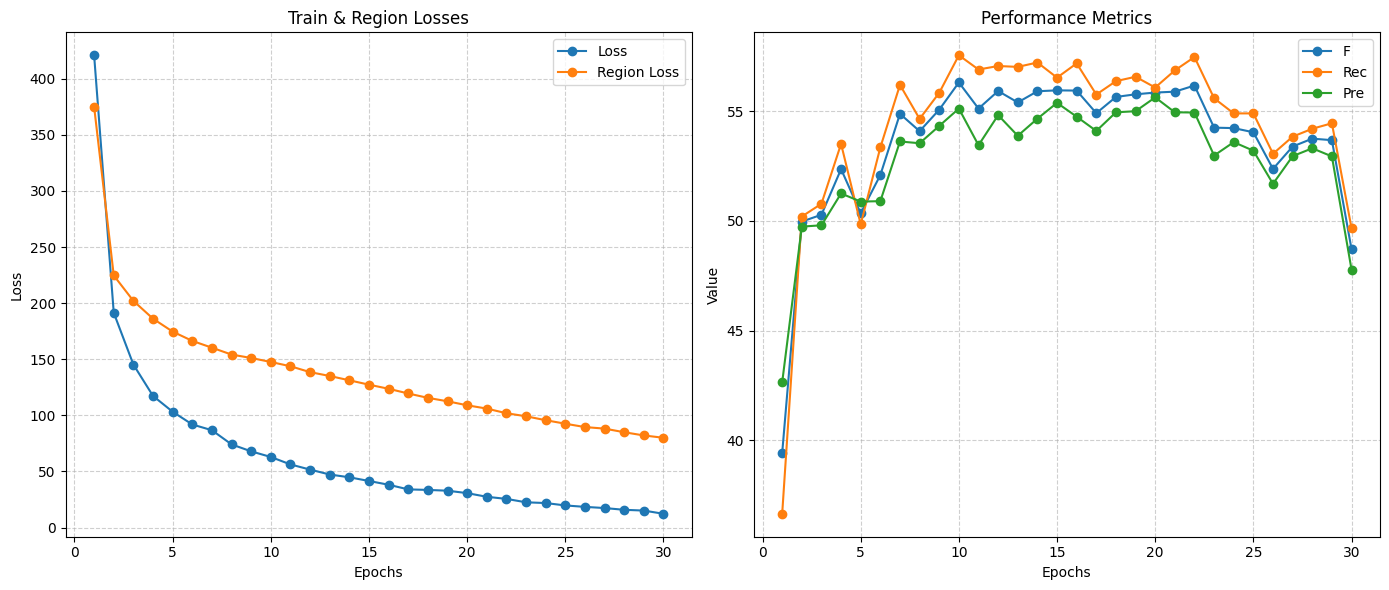

In [34]:
plot_losses_and_metrics(losses, region_losses, resses) 

In [35]:
%%time

model = BartSeq2SeqModel.build_model(bart_name, tokenizer, label_ids=label_ids, decoder_type=decoder_type,
                                     use_encoder_mlp=use_encoder_mlp,box_num = box_num)

model = SequenceGeneratorModel(model, bos_token_id=bos_token_id,
                               eos_token_id=eos_token_id,
                               max_length=max_len, max_len_a=max_len_a,num_beams=num_beams, do_sample=False,
                               repetition_penalty=1, length_penalty=length_penalty, pad_token_id=eos_token_id,
                               restricter=None, top_k = 1
                               )

if torch.cuda.is_available():
    device_eval = 'cuda'
else:
    device_eval = 'cpu'
    
device_eval = torch.device(device_eval)
load_model(model, save_path)
model.to(device_eval)
model.eval()


train_res = Inference(eval_data=train_dataset, model=model, device=device_eval, metric = metric)
print("train: "+str(train_res))
dev_res = Inference(eval_data=eval_dataset, model=model, device=device_eval, metric = metric)
print("dev: "+str(dev_res))
test_res = Inference(eval_data=test_dataset, model=model, device=device_eval, metric = metric)
print("test: "+str(test_res))

Some weights of BartModel were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['encoder.img_proj.bias', 'encoder.img_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Inference: 100%|██████████| 110/110 [00:25<00:00,  4.25it/s]


train: {'f': 69.53, 'rec': 70.33, 'pre': 68.75, 'em': 0.6639, 'uc': 2463, 'nc': 5821, 'tc': 11091, 'sc': 11371}


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.38it/s]


dev: {'f': 56.31, 'rec': 57.55, 'pre': 55.12, 'em': 0.452, 'uc': 442, 'nc': 968, 'tc': 1985, 'sc': 2120}


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.27it/s]

test: {'f': 55.64, 'rec': 56.27, 'pre': 55.02, 'em': 0.462, 'uc': 466, 'nc': 965, 'tc': 2049, 'sc': 2187}
CPU times: user 39.2 s, sys: 1.03 s, total: 40.2 s
Wall time: 39.7 s


# Ablation Study (only text)

Ablation study on text only made by just zeroing the image feature and putting region_loss_ratio=0

In [37]:
%%time
max_dev_f = 0.
best_dev = {}
save_path = '/kaggle/working/best_model_text_only.safetensors'
losses = []
region_losses = []
resses = []


model = BartSeq2SeqModel.build_model(bart_name, tokenizer, label_ids=label_ids, decoder_type=decoder_type,
                                     use_encoder_mlp=use_encoder_mlp,box_num = box_num)

model = SequenceGeneratorModel(model, bos_token_id=bos_token_id,
                               eos_token_id=eos_token_id,
                               max_length=max_len, max_len_a=max_len_a,num_beams=num_beams, do_sample=False,
                               repetition_penalty=1, length_penalty=length_penalty, pad_token_id=eos_token_id,
                               restricter=None, top_k = 1
                               )

metric = Seq2SeqSpanMetric(eos_token_id, num_labels=len(label_ids), region_num =box_num, target_type=target_type,print_mode = False )
parameters =[]
params = {'lr':lr}
params['params'] = [param for name, param in model.named_parameters() ]
parameters.append(params)

optimizer = optim.AdamW(parameters)

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(device)

device = torch.device(device)
model.to(device)

for train_idx in range(n_epochs):
    print("-"*12+"Epoch: "+str(train_idx)+"-"*12)

    model.train()
    train_loss, train_region_loss = Training(train_idx=train_idx,train_data=train_dataset, model=model, device=device,
                                                optimizer=optimizer, only_text=True)


    model.eval()
    dev_res = Inference(eval_data=eval_dataset, model=model, device=device, metric = metric, only_text=True)
    dev_f = dev_res['f']
    print("dev: "+str(dev_res))

    losses.append(train_loss)
    region_losses.append(train_region_loss)
    resses.append(dev_res)


    if dev_f >= max_dev_f:
        max_dev_f = dev_f
        if save_model_:
            save_model(model, save_path)
        best_dev = dev_res
        best_dev['epoch'] = train_idx

print("best_dev: "+str(best_dev))

Some weights of BartModel were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['encoder.img_proj.bias', 'encoder.img_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda
------------Epoch: 0------------


Epoch 0 Training: 100%|██████████| 219/219 [00:36<00:00,  6.04it/s]


train_loss: 402.480701
train_region_loss: 533.074043


Inference: 100%|██████████| 24/24 [00:04<00:00,  5.03it/s]


dev: {'f': 27.32, 'rec': 25.35, 'pre': 29.63, 'em': 0.2587, 'uc': 88, 'nc': 533, 'tc': 1382, 'sc': 1550}
------------Epoch: 1------------


Epoch 1 Training: 100%|██████████| 219/219 [00:36<00:00,  6.06it/s]


train_loss: 183.342128
train_region_loss: 535.575555


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.44it/s]


dev: {'f': 37.74, 'rec': 38.2, 'pre': 37.29, 'em': 0.3327, 'uc': 95, 'nc': 841, 'tc': 1790, 'sc': 1923}
------------Epoch: 2------------


Epoch 2 Training: 100%|██████████| 219/219 [00:36<00:00,  6.04it/s]


train_loss: 136.625678
train_region_loss: 545.120319


Inference: 100%|██████████| 24/24 [00:06<00:00,  3.98it/s]


dev: {'f': 38.37, 'rec': 38.9, 'pre': 37.86, 'em': 0.3747, 'uc': 109, 'nc': 844, 'tc': 1882, 'sc': 2017}
------------Epoch: 3------------


Epoch 3 Training: 100%|██████████| 219/219 [00:36<00:00,  6.03it/s]


train_loss: 117.879035
train_region_loss: 544.536824


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.28it/s]


dev: {'f': 38.76, 'rec': 39.39, 'pre': 38.14, 'em': 0.392, 'uc': 117, 'nc': 848, 'tc': 1911, 'sc': 2045}
------------Epoch: 4------------


Epoch 4 Training: 100%|██████████| 219/219 [00:36<00:00,  6.04it/s]


train_loss: 103.088233
train_region_loss: 550.689707


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.65it/s]


dev: {'f': 36.72, 'rec': 35.22, 'pre': 38.36, 'em': 0.3773, 'uc': 99, 'nc': 764, 'tc': 1680, 'sc': 1823}
------------Epoch: 5------------


Epoch 5 Training: 100%|██████████| 219/219 [00:36<00:00,  6.05it/s]


train_loss: 97.320056
train_region_loss: 557.898493


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.26it/s]


dev: {'f': 42.16, 'rec': 42.69, 'pre': 41.64, 'em': 0.4253, 'uc': 113, 'nc': 933, 'tc': 1940, 'sc': 2076}
------------Epoch: 6------------


Epoch 6 Training: 100%|██████████| 219/219 [00:36<00:00,  6.03it/s]


train_loss: 79.954319
train_region_loss: 559.124854


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.33it/s]


dev: {'f': 41.13, 'rec': 41.1, 'pre': 41.15, 'em': 0.4307, 'uc': 124, 'nc': 883, 'tc': 1928, 'sc': 2060}
------------Epoch: 7------------


Epoch 7 Training: 100%|██████████| 219/219 [00:36<00:00,  6.04it/s]


train_loss: 72.677155
train_region_loss: 560.625690


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.26it/s]


dev: {'f': 39.72, 'rec': 41.02, 'pre': 38.51, 'em': 0.4067, 'uc': 126, 'nc': 879, 'tc': 1968, 'sc': 2102}
------------Epoch: 8------------


Epoch 8 Training: 100%|██████████| 219/219 [00:36<00:00,  6.03it/s]


train_loss: 65.905498
train_region_loss: 559.506055


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.30it/s]


dev: {'f': 41.36, 'rec': 42.29, 'pre': 40.47, 'em': 0.426, 'uc': 124, 'nc': 912, 'tc': 1967, 'sc': 2112}
------------Epoch: 9------------


Epoch 9 Training: 100%|██████████| 219/219 [00:36<00:00,  6.04it/s]


train_loss: 59.603329
train_region_loss: 570.355777


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.17it/s]


dev: {'f': 42.27, 'rec': 43.51, 'pre': 41.09, 'em': 0.4327, 'uc': 123, 'nc': 943, 'tc': 1979, 'sc': 2124}
------------Epoch: 10------------


Epoch 10 Training: 100%|██████████| 219/219 [00:36<00:00,  6.03it/s]


train_loss: 54.650633
train_region_loss: 567.279187


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.21it/s]


dev: {'f': 43.21, 'rec': 44.41, 'pre': 42.07, 'em': 0.432, 'uc': 107, 'nc': 981, 'tc': 1985, 'sc': 2128}
------------Epoch: 11------------


Epoch 11 Training: 100%|██████████| 219/219 [00:36<00:00,  6.05it/s]


train_loss: 50.593573
train_region_loss: 574.450913


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.29it/s]


dev: {'f': 42.02, 'rec': 43.1, 'pre': 40.99, 'em': 0.4373, 'uc': 118, 'nc': 938, 'tc': 1988, 'sc': 2137}
------------Epoch: 12------------


Epoch 12 Training: 100%|██████████| 219/219 [00:36<00:00,  6.07it/s]


train_loss: 46.424256
train_region_loss: 576.510989


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.37it/s]


dev: {'f': 43.94, 'rec': 44.08, 'pre': 43.8, 'em': 0.4533, 'uc': 104, 'nc': 976, 'tc': 1960, 'sc': 2105}
------------Epoch: 13------------


Epoch 13 Training: 100%|██████████| 219/219 [00:36<00:00,  6.03it/s]


train_loss: 44.179176
train_region_loss: 565.106345


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]


dev: {'f': 42.04, 'rec': 42.37, 'pre': 41.72, 'em': 0.45, 'uc': 120, 'nc': 918, 'tc': 1957, 'sc': 2104}
------------Epoch: 14------------


Epoch 14 Training: 100%|██████████| 219/219 [00:36<00:00,  6.03it/s]


train_loss: 40.929086
train_region_loss: 565.147304


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.37it/s]


dev: {'f': 40.58, 'rec': 41.39, 'pre': 39.81, 'em': 0.44, 'uc': 124, 'nc': 890, 'tc': 1981, 'sc': 2125}
------------Epoch: 15------------


Epoch 15 Training: 100%|██████████| 219/219 [00:36<00:00,  6.04it/s]


train_loss: 36.633465
train_region_loss: 572.514865


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]


dev: {'f': 41.64, 'rec': 42.2, 'pre': 41.1, 'em': 0.4473, 'uc': 116, 'nc': 918, 'tc': 1970, 'sc': 2128}
------------Epoch: 16------------


Epoch 16 Training: 100%|██████████| 219/219 [00:36<00:00,  6.03it/s]


train_loss: 34.289718
train_region_loss: 574.598958


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.19it/s]


dev: {'f': 41.52, 'rec': 42.9, 'pre': 40.22, 'em': 0.4313, 'uc': 116, 'nc': 935, 'tc': 1994, 'sc': 2150}
------------Epoch: 17------------


Epoch 17 Training: 100%|██████████| 219/219 [00:36<00:00,  6.04it/s]


train_loss: 31.219097
train_region_loss: 570.784740


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.25it/s]


dev: {'f': 40.25, 'rec': 41.31, 'pre': 39.24, 'em': 0.428, 'uc': 123, 'nc': 889, 'tc': 2000, 'sc': 2153}
------------Epoch: 18------------


Epoch 18 Training: 100%|██████████| 219/219 [00:36<00:00,  6.01it/s]


train_loss: 28.986537
train_region_loss: 566.094556


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.28it/s]


dev: {'f': 43.24, 'rec': 44.53, 'pre': 42.03, 'em': 0.44, 'uc': 114, 'nc': 977, 'tc': 1990, 'sc': 2144}
------------Epoch: 19------------


Epoch 19 Training: 100%|██████████| 219/219 [00:36<00:00,  6.06it/s]


train_loss: 26.594547
train_region_loss: 565.107661


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.30it/s]


dev: {'f': 42.37, 'rec': 43.43, 'pre': 41.35, 'em': 0.442, 'uc': 112, 'nc': 952, 'tc': 2008, 'sc': 2153}
------------Epoch: 20------------


Epoch 20 Training: 100%|██████████| 219/219 [00:36<00:00,  6.04it/s]


train_loss: 24.511893
train_region_loss: 563.798077


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.27it/s]


dev: {'f': 40.88, 'rec': 42.24, 'pre': 39.59, 'em': 0.4213, 'uc': 116, 'nc': 919, 'tc': 2003, 'sc': 2152}
------------Epoch: 21------------


Epoch 21 Training: 100%|██████████| 219/219 [00:36<00:00,  6.05it/s]


train_loss: 22.030999
train_region_loss: 571.914092


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.20it/s]


dev: {'f': 40.45, 'rec': 41.51, 'pre': 39.45, 'em': 0.424, 'uc': 118, 'nc': 899, 'tc': 1997, 'sc': 2146}
------------Epoch: 22------------


Epoch 22 Training: 100%|██████████| 219/219 [00:36<00:00,  6.04it/s]


train_loss: 20.517948
train_region_loss: 567.425984


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.24it/s]


dev: {'f': 37.99, 'rec': 38.94, 'pre': 37.08, 'em': 0.4127, 'uc': 129, 'nc': 825, 'tc': 2013, 'sc': 2156}
------------Epoch: 23------------


Epoch 23 Training: 100%|██████████| 219/219 [00:36<00:00,  6.03it/s]


train_loss: 20.225196
train_region_loss: 556.471802


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.31it/s]


dev: {'f': 40.64, 'rec': 41.14, 'pre': 40.14, 'em': 0.4327, 'uc': 117, 'nc': 891, 'tc': 1987, 'sc': 2129}
------------Epoch: 24------------


Epoch 24 Training: 100%|██████████| 219/219 [00:36<00:00,  6.04it/s]


train_loss: 17.272930
train_region_loss: 552.830457


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.25it/s]


dev: {'f': 41.27, 'rec': 42.57, 'pre': 40.05, 'em': 0.4227, 'uc': 113, 'nc': 930, 'tc': 2000, 'sc': 2145}
------------Epoch: 25------------


Epoch 25 Training: 100%|██████████| 219/219 [00:36<00:00,  6.07it/s]


train_loss: 15.861678
train_region_loss: 548.472869


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.28it/s]


dev: {'f': 40.33, 'rec': 41.14, 'pre': 39.54, 'em': 0.426, 'uc': 109, 'nc': 899, 'tc': 1992, 'sc': 2146}
------------Epoch: 26------------


Epoch 26 Training: 100%|██████████| 219/219 [00:36<00:00,  6.05it/s]


train_loss: 19.949466
train_region_loss: 546.684170


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.32it/s]


dev: {'f': 40.6, 'rec': 42.08, 'pre': 39.22, 'em': 0.4113, 'uc': 115, 'nc': 916, 'tc': 2004, 'sc': 2158}
------------Epoch: 27------------


Epoch 27 Training: 100%|██████████| 219/219 [00:36<00:00,  6.01it/s]


train_loss: 15.148035
train_region_loss: 541.346600


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.25it/s]


dev: {'f': 41.25, 'rec': 42.16, 'pre': 40.38, 'em': 0.438, 'uc': 111, 'nc': 922, 'tc': 1984, 'sc': 2136}
------------Epoch: 28------------


Epoch 28 Training: 100%|██████████| 219/219 [00:36<00:00,  6.02it/s]


train_loss: 12.161830
train_region_loss: 540.724743


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.23it/s]


dev: {'f': 43.18, 'rec': 44.78, 'pre': 41.7, 'em': 0.4313, 'uc': 106, 'nc': 991, 'tc': 2024, 'sc': 2171}
------------Epoch: 29------------


Epoch 29 Training: 100%|██████████| 219/219 [00:36<00:00,  6.04it/s]


train_loss: 11.296440
train_region_loss: 541.006467


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.27it/s]

dev: {'f': 41.72, 'rec': 43.06, 'pre': 40.47, 'em': 0.416, 'uc': 105, 'nc': 950, 'tc': 2015, 'sc': 2167}
best_dev: {'f': 43.94, 'rec': 44.08, 'pre': 43.8, 'em': 0.4533, 'uc': 104, 'nc': 976, 'tc': 1960, 'sc': 2105, 'epoch': 12}
CPU times: user 20min 59s, sys: 13.6 s, total: 21min 12s
Wall time: 21min 13s


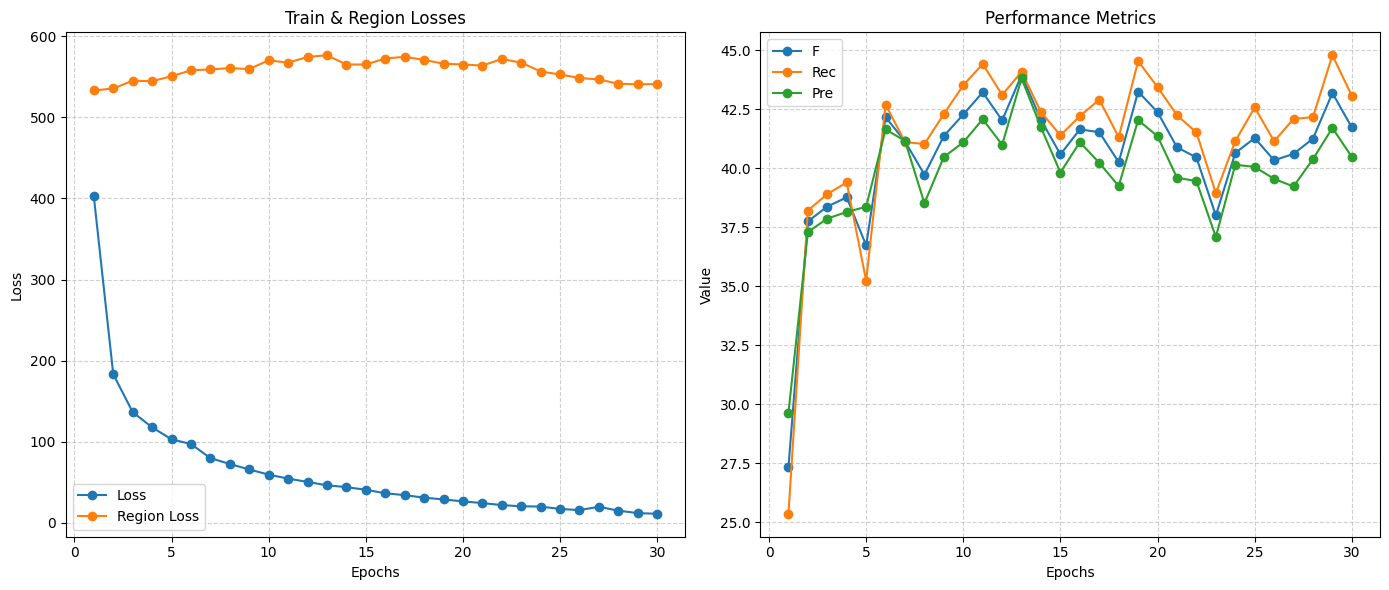

In [38]:
plot_losses_and_metrics(losses, region_losses, resses) 

In [39]:
%%time

model = BartSeq2SeqModel.build_model(bart_name, tokenizer, label_ids=label_ids, decoder_type=decoder_type,
                                     use_encoder_mlp=use_encoder_mlp,box_num = box_num)

model = SequenceGeneratorModel(model, bos_token_id=bos_token_id,
                               eos_token_id=eos_token_id,
                               max_length=max_len, max_len_a=max_len_a,num_beams=num_beams, do_sample=False,
                               repetition_penalty=1, length_penalty=length_penalty, pad_token_id=eos_token_id,
                               restricter=None, top_k = 1)


if torch.cuda.is_available():
    device_eval = 'cuda'
else:
    device_eval = 'cpu'
    
device_eval = torch.device(device_eval)
load_model(model, save_path)
model.to(device_eval)
model.eval()


train_res = Inference(eval_data=train_dataset, model=model, device=device_eval, metric = metric, text_only=True)
print("train: "+str(train_res))
dev_res = Inference(eval_data=eval_dataset, model=model, device=device_eval, metric = metric, text_only=True)
print("dev: "+str(dev_res))
test_res = Inference(eval_data=test_dataset, model=model, device=device_eval, metric = metric, text_only=True)
print("test: "+str(test_res))

Some weights of BartModel were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['encoder.img_proj.bias', 'encoder.img_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Inference: 100%|██████████| 110/110 [00:23<00:00,  4.72it/s]


train: {'f': 57.8, 'rec': 57.83, 'pre': 57.77, 'em': 0.7137, 'uc': 540, 'nc': 6272, 'tc': 11362, 'sc': 11517}


Inference: 100%|██████████| 24/24 [00:04<00:00,  5.05it/s]


dev: {'f': 43.45, 'rec': 43.67, 'pre': 43.23, 'em': 0.448, 'uc': 95, 'nc': 975, 'tc': 1965, 'sc': 2106}


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.97it/s]

test: {'f': 41.93, 'rec': 41.84, 'pre': 42.02, 'em': 0.438, 'uc': 78, 'nc': 986, 'tc': 2020, 'sc': 2159}
CPU times: user 35 s, sys: 1.07 s, total: 36.1 s
Wall time: 35.7 s


Ablation study made by changing the architecture to process only the text

In [40]:
%%time
max_dev_f = 0.
best_dev = {}
save_path = '/kaggle/working/best_model_text_only_v2.safetensors'
losses = []
region_losses = []
resses = []


model = BartSeq2SeqModel.build_model(bart_name, tokenizer, label_ids=label_ids, decoder_type=decoder_type,
                                     use_encoder_mlp=use_encoder_mlp,box_num = box_num)

model = SequenceGeneratorModel(model, bos_token_id=bos_token_id,
                               eos_token_id=eos_token_id,
                               max_length=max_len, max_len_a=max_len_a,num_beams=num_beams, do_sample=False,
                               repetition_penalty=1, length_penalty=length_penalty, pad_token_id=eos_token_id,
                               restricter=None, top_k = 1
                               )

metric = Seq2SeqSpanMetric(eos_token_id, num_labels=len(label_ids), region_num =box_num, target_type=target_type,print_mode = False )
parameters =[]
params = {'lr':lr}
params['params'] = [param for name, param in model.named_parameters() ]
parameters.append(params)

optimizer = optim.AdamW(parameters)

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(device)

device = torch.device(device)
model.to(device)

for train_idx in range(n_epochs):
    print("-"*12+"Epoch: "+str(train_idx)+"-"*12)

    model.train()
    train_loss, train_region_loss = Training(train_idx=train_idx,train_data=train_dataset, model=model, device=device,
                                                optimizer=optimizer, text_only=True)


    model.eval()
    dev_res = Inference(eval_data=eval_dataset, model=model, device=device, metric = metric, text_only=True)
    dev_f = dev_res['f']
    print("dev: "+str(dev_res))

    losses.append(train_loss)
    region_losses.append(train_region_loss)
    resses.append(dev_res)


    if dev_f >= max_dev_f:
        max_dev_f = dev_f
        if save_model_:
            save_model(model, save_path)
        best_dev = dev_res
        best_dev['epoch'] = train_idx

print("best_dev: "+str(best_dev))

Some weights of BartModel were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['encoder.img_proj.bias', 'encoder.img_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda
------------Epoch: 0------------


Epoch 0 Training: 100%|██████████| 219/219 [00:30<00:00,  7.21it/s]


train_loss: 384.969407
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  5.57it/s]


dev: {'f': 31.33, 'rec': 29.88, 'pre': 32.93, 'em': 0.2687, 'uc': 91, 'nc': 641, 'tc': 1495, 'sc': 1677}
------------Epoch: 1------------


Epoch 1 Training: 100%|██████████| 219/219 [00:30<00:00,  7.24it/s]


train_loss: 173.582650
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  5.07it/s]


dev: {'f': 35.94, 'rec': 35.43, 'pre': 36.47, 'em': 0.344, 'uc': 94, 'nc': 774, 'tc': 1709, 'sc': 1846}
------------Epoch: 2------------


Epoch 2 Training: 100%|██████████| 219/219 [00:30<00:00,  7.19it/s]


train_loss: 133.491699
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.78it/s]


dev: {'f': 38.15, 'rec': 38.65, 'pre': 37.65, 'em': 0.368, 'uc': 105, 'nc': 842, 'tc': 1877, 'sc': 2009}
------------Epoch: 3------------


Epoch 3 Training: 100%|██████████| 219/219 [00:30<00:00,  7.19it/s]


train_loss: 111.483791
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.87it/s]


dev: {'f': 38.55, 'rec': 38.53, 'pre': 38.56, 'em': 0.4053, 'uc': 115, 'nc': 829, 'tc': 1894, 'sc': 2034}
------------Epoch: 4------------


Epoch 4 Training: 100%|██████████| 219/219 [00:30<00:00,  7.21it/s]


train_loss: 97.455705
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.70it/s]


dev: {'f': 42.08, 'rec': 43.35, 'pre': 40.89, 'em': 0.4147, 'uc': 106, 'nc': 956, 'tc': 1958, 'sc': 2103}
------------Epoch: 5------------


Epoch 5 Training: 100%|██████████| 219/219 [00:30<00:00,  7.17it/s]


train_loss: 84.171511
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.83it/s]


dev: {'f': 41.1, 'rec': 41.8, 'pre': 40.43, 'em': 0.4293, 'uc': 102, 'nc': 922, 'tc': 1966, 'sc': 2107}
------------Epoch: 6------------


Epoch 6 Training: 100%|██████████| 219/219 [00:30<00:00,  7.20it/s]


train_loss: 75.895309
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.79it/s]


dev: {'f': 41.47, 'rec': 42.04, 'pre': 40.92, 'em': 0.432, 'uc': 103, 'nc': 927, 'tc': 1959, 'sc': 2096}
------------Epoch: 7------------


Epoch 7 Training: 100%|██████████| 219/219 [00:30<00:00,  7.21it/s]


train_loss: 67.751436
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.78it/s]


dev: {'f': 42.02, 'rec': 42.78, 'pre': 41.29, 'em': 0.4347, 'uc': 109, 'nc': 939, 'tc': 1978, 'sc': 2117}
------------Epoch: 8------------


Epoch 8 Training: 100%|██████████| 219/219 [00:30<00:00,  7.20it/s]


train_loss: 61.379461
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.75it/s]


dev: {'f': 43.27, 'rec': 44.45, 'pre': 42.16, 'em': 0.43, 'uc': 94, 'nc': 995, 'tc': 1996, 'sc': 2137}
------------Epoch: 9------------


Epoch 9 Training: 100%|██████████| 219/219 [00:30<00:00,  7.19it/s]


train_loss: 57.307738
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.91it/s]


dev: {'f': 41.18, 'rec': 41.96, 'pre': 40.42, 'em': 0.4407, 'uc': 115, 'nc': 913, 'tc': 1969, 'sc': 2108}
------------Epoch: 10------------


Epoch 10 Training: 100%|██████████| 219/219 [00:30<00:00,  7.19it/s]


train_loss: 54.195749
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.91it/s]


dev: {'f': 40.49, 'rec': 41.02, 'pre': 39.98, 'em': 0.44, 'uc': 117, 'nc': 888, 'tc': 1980, 'sc': 2114}
------------Epoch: 11------------


Epoch 11 Training: 100%|██████████| 219/219 [00:30<00:00,  7.17it/s]


train_loss: 48.192851
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.83it/s]


dev: {'f': 41.24, 'rec': 42.45, 'pre': 40.09, 'em': 0.4293, 'uc': 107, 'nc': 933, 'tc': 1987, 'sc': 2132}
------------Epoch: 12------------


Epoch 12 Training: 100%|██████████| 219/219 [00:30<00:00,  7.19it/s]


train_loss: 43.139949
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.89it/s]


dev: {'f': 41.66, 'rec': 42.29, 'pre': 41.06, 'em': 0.4487, 'uc': 110, 'nc': 926, 'tc': 1993, 'sc': 2137}
------------Epoch: 13------------


Epoch 13 Training: 100%|██████████| 219/219 [00:30<00:00,  7.21it/s]


train_loss: 40.178558
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.82it/s]


dev: {'f': 39.35, 'rec': 40.33, 'pre': 38.43, 'em': 0.426, 'uc': 124, 'nc': 864, 'tc': 2001, 'sc': 2150}
------------Epoch: 14------------


Epoch 14 Training: 100%|██████████| 219/219 [00:30<00:00,  7.17it/s]


train_loss: 35.790788
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.48it/s]


dev: {'f': 40.04, 'rec': 40.33, 'pre': 39.76, 'em': 0.4413, 'uc': 118, 'nc': 870, 'tc': 1970, 'sc': 2118}
------------Epoch: 15------------


Epoch 15 Training: 100%|██████████| 219/219 [00:30<00:00,  7.21it/s]


train_loss: 35.015677
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.74it/s]


dev: {'f': 38.55, 'rec': 39.39, 'pre': 37.74, 'em': 0.43, 'uc': 123, 'nc': 842, 'tc': 1989, 'sc': 2129}
------------Epoch: 16------------


Epoch 16 Training: 100%|██████████| 219/219 [00:30<00:00,  7.20it/s]


train_loss: 32.341844
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:05<00:00,  4.78it/s]


dev: {'f': 40.85, 'rec': 42.41, 'pre': 39.4, 'em': 0.4273, 'uc': 115, 'nc': 924, 'tc': 2010, 'sc': 2164}
------------Epoch: 17------------


Epoch 17 Training: 100%|██████████| 219/219 [00:30<00:00,  7.22it/s]


train_loss: 28.905785
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  5.05it/s]


dev: {'f': 40.09, 'rec': 40.2, 'pre': 39.98, 'em': 0.4313, 'uc': 117, 'nc': 868, 'tc': 1950, 'sc': 2096}
------------Epoch: 18------------


Epoch 18 Training: 100%|██████████| 219/219 [00:30<00:00,  7.23it/s]


train_loss: 27.670538
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.86it/s]


dev: {'f': 41.31, 'rec': 42.37, 'pre': 40.3, 'em': 0.426, 'uc': 105, 'nc': 933, 'tc': 1978, 'sc': 2132}
------------Epoch: 19------------


Epoch 19 Training: 100%|██████████| 219/219 [00:30<00:00,  7.23it/s]


train_loss: 24.911695
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.92it/s]


dev: {'f': 43.07, 'rec': 43.67, 'pre': 42.48, 'em': 0.4433, 'uc': 99, 'nc': 971, 'tc': 1982, 'sc': 2118}
------------Epoch: 20------------


Epoch 20 Training: 100%|██████████| 219/219 [00:30<00:00,  7.23it/s]


train_loss: 22.578889
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  5.00it/s]


dev: {'f': 40.57, 'rec': 41.27, 'pre': 39.9, 'em': 0.4293, 'uc': 105, 'nc': 906, 'tc': 1972, 'sc': 2126}
------------Epoch: 21------------


Epoch 21 Training: 100%|██████████| 219/219 [00:30<00:00,  7.23it/s]


train_loss: 25.548873
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.93it/s]


dev: {'f': 39.18, 'rec': 40.16, 'pre': 38.24, 'em': 0.4273, 'uc': 120, 'nc': 864, 'tc': 1993, 'sc': 2147}
------------Epoch: 22------------


Epoch 22 Training: 100%|██████████| 219/219 [00:30<00:00,  7.23it/s]


train_loss: 19.768550
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.98it/s]


dev: {'f': 40.26, 'rec': 40.98, 'pre': 39.57, 'em': 0.43, 'uc': 115, 'nc': 889, 'tc': 1986, 'sc': 2137}
------------Epoch: 23------------


Epoch 23 Training: 100%|██████████| 219/219 [00:30<00:00,  7.22it/s]


train_loss: 16.790776
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.96it/s]


dev: {'f': 40.55, 'rec': 41.27, 'pre': 39.85, 'em': 0.4267, 'uc': 113, 'nc': 898, 'tc': 2006, 'sc': 2149}
------------Epoch: 24------------


Epoch 24 Training: 100%|██████████| 219/219 [00:30<00:00,  7.20it/s]


train_loss: 15.071228
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.85it/s]


dev: {'f': 39.67, 'rec': 40.82, 'pre': 38.6, 'em': 0.4233, 'uc': 120, 'nc': 880, 'tc': 2018, 'sc': 2171}
------------Epoch: 25------------


Epoch 25 Training: 100%|██████████| 219/219 [00:30<00:00,  7.26it/s]


train_loss: 13.713946
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.94it/s]


dev: {'f': 40.62, 'rec': 41.22, 'pre': 40.03, 'em': 0.4227, 'uc': 112, 'nc': 898, 'tc': 1978, 'sc': 2117}
------------Epoch: 26------------


Epoch 26 Training: 100%|██████████| 219/219 [00:30<00:00,  7.23it/s]


train_loss: 12.617124
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.92it/s]


dev: {'f': 41.23, 'rec': 42.2, 'pre': 40.3, 'em': 0.442, 'uc': 110, 'nc': 924, 'tc': 2006, 'sc': 2154}
------------Epoch: 27------------


Epoch 27 Training: 100%|██████████| 219/219 [00:30<00:00,  7.25it/s]


train_loss: 11.225575
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.87it/s]


dev: {'f': 41.18, 'rec': 42.16, 'pre': 40.24, 'em': 0.438, 'uc': 109, 'nc': 924, 'tc': 2016, 'sc': 2159}
------------Epoch: 28------------


Epoch 28 Training: 100%|██████████| 219/219 [00:30<00:00,  7.25it/s]


train_loss: 10.433896
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.96it/s]


dev: {'f': 40.18, 'rec': 40.9, 'pre': 39.5, 'em': 0.424, 'uc': 108, 'nc': 894, 'tc': 1973, 'sc': 2132}
------------Epoch: 29------------


Epoch 29 Training: 100%|██████████| 219/219 [00:30<00:00,  7.27it/s]


train_loss: 9.476066
train_region_loss: 0.000000


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.91it/s]

dev: {'f': 40.22, 'rec': 41.02, 'pre': 39.46, 'em': 0.4213, 'uc': 103, 'nc': 902, 'tc': 1978, 'sc': 2131}
best_dev: {'f': 43.27, 'rec': 44.45, 'pre': 42.16, 'em': 0.43, 'uc': 94, 'nc': 995, 'tc': 1996, 'sc': 2137, 'epoch': 8}
CPU times: user 17min 41s, sys: 10.9 s, total: 17min 52s
Wall time: 17min 51s


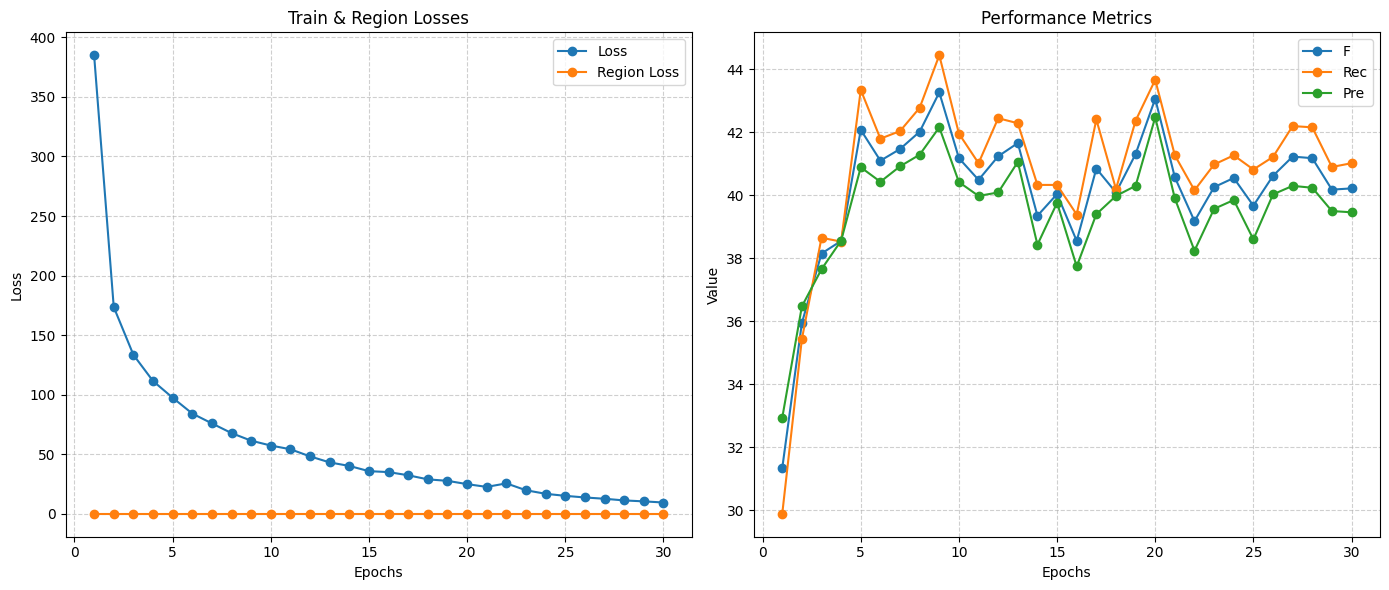

In [41]:
plot_losses_and_metrics(losses, region_losses, resses) 

In [42]:
%%time

model = BartSeq2SeqModel.build_model(bart_name, tokenizer, label_ids=label_ids, decoder_type=decoder_type,
                                     use_encoder_mlp=use_encoder_mlp,box_num = box_num)

model = SequenceGeneratorModel(model, bos_token_id=bos_token_id,
                               eos_token_id=eos_token_id,
                               max_length=max_len, max_len_a=max_len_a,num_beams=num_beams, do_sample=False,
                               repetition_penalty=1, length_penalty=length_penalty, pad_token_id=eos_token_id,
                               restricter=None, top_k = 1)


if torch.cuda.is_available():
    device_eval = 'cuda'
else:
    device_eval = 'cpu'
    
device_eval = torch.device(device_eval)
load_model(model, save_path)
model.to(device_eval)
model.eval()


train_res = Inference(eval_data=train_dataset, model=model, device=device_eval, metric = metric, text_only=True)
train_f = train_res['f']
print("train: "+str(train_res))

dev_res = Inference(eval_data=eval_dataset, model=model, device=device_eval, metric = metric, text_only=True)
dev_f = dev_res['f']
print("dev: "+str(dev_res))
test_res = Inference(eval_data=test_dataset, model=model, device=device_eval, metric = metric, text_only=True)
test_f = test_res['f']
print("test: "+str(test_res))

Some weights of BartModel were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['encoder.img_proj.bias', 'encoder.img_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Inference: 100%|██████████| 110/110 [00:22<00:00,  4.81it/s]


train: {'f': 54.27, 'rec': 54.8, 'pre': 53.74, 'em': 0.6306, 'uc': 494, 'nc': 5961, 'tc': 11099, 'sc': 11383}


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.98it/s]


dev: {'f': 43.27, 'rec': 44.45, 'pre': 42.16, 'em': 0.43, 'uc': 94, 'nc': 995, 'tc': 1996, 'sc': 2137}


Inference: 100%|██████████| 24/24 [00:04<00:00,  4.91it/s]

test: {'f': 41.36, 'rec': 41.76, 'pre': 40.96, 'em': 0.4287, 'uc': 80, 'nc': 982, 'tc': 2036, 'sc': 2179}
CPU times: user 34.7 s, sys: 997 ms, total: 35.7 s
Wall time: 35.3 s


# Model Compression

Performance of the model on cpu

In [37]:
%%time
model = BartSeq2SeqModel.build_model(bart_name, tokenizer, label_ids=label_ids, decoder_type=decoder_type,
                                     use_encoder_mlp=use_encoder_mlp,box_num = box_num)

model = SequenceGeneratorModel(model, bos_token_id=bos_token_id,
                               eos_token_id=eos_token_id,
                               max_length=max_len, max_len_a=max_len_a,num_beams=num_beams, do_sample=False,
                               repetition_penalty=1, length_penalty=length_penalty, pad_token_id=eos_token_id,
                               restricter=None, top_k = 1)

save_path = '/kaggle/working/best_model.safetensors'
device_eval = 'cpu'
device_eval = torch.device(device_eval)
load_model(model, save_path)
model.to(device_eval)
model.eval()

metric = Seq2SeqSpanMetric(eos_token_id, num_labels=len(label_ids), region_num =box_num, target_type=target_type,print_mode = False )


train_res = Inference(eval_data=train_dataset, model=model, device=device_eval, metric = metric)
train_f = train_res['f']
print("train: "+str(train_res))
dev_res = Inference(eval_data=eval_dataset, model=model, device=device_eval, metric = metric)
dev_f = dev_res['f']
print("dev: "+str(dev_res))
test_res = Inference(eval_data=test_dataset, model=model, device=device_eval, metric = metric)
test_f = test_res['f']
print("test: "+str(test_res))

Some weights of BartModel were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['encoder.img_proj.bias', 'encoder.img_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Inference: 100%|██████████| 110/110 [13:37<00:00,  7.43s/it]


train: {'f': 73.01, 'rec': 73.88, 'pre': 72.16, 'em': 0.7151, 'uc': 2566, 'nc': 6136, 'tc': 11339, 'sc': 11539}


Inference: 100%|██████████| 24/24 [02:54<00:00,  7.25s/it]


dev: {'f': 56.76, 'rec': 58.57, 'pre': 55.07, 'em': 0.4453, 'uc': 445, 'nc': 990, 'tc': 1996, 'sc': 2145}


Inference: 100%|██████████| 24/24 [02:53<00:00,  7.21s/it]

test: {'f': 55.54, 'rec': 56.67, 'pre': 54.46, 'em': 0.45, 'uc': 456, 'nc': 985, 'tc': 2037, 'sc': 2196}
CPU times: user 35min 2s, sys: 3min 25s, total: 38min 27s
Wall time: 19min 27s


In [14]:
import torch.quantization
from torch import nn
from torch.ao.quantization.qconfig_mapping import QConfigMapping
from torch.ao.quantization import prepare, convert 
from torch.ao.quantization import QuantStub, DeQuantStub
#from torch.ao.quantization import add_quant_dequant

model = BartSeq2SeqModel.build_model(bart_name, tokenizer, label_ids=label_ids, decoder_type=decoder_type,
                                     use_encoder_mlp=use_encoder_mlp,box_num = box_num)


model = SequenceGeneratorModel(model, bos_token_id=bos_token_id,
                               eos_token_id=eos_token_id,
                               max_length=max_len, max_len_a=max_len_a,num_beams=num_beams, do_sample=False,
                               repetition_penalty=1, length_penalty=length_penalty, pad_token_id=eos_token_id,
                               restricter=None, top_k = 1)


save_path = '/kaggle/working/best_model.safetensors'
load_model(model, save_path)
torch.save(model.state_dict(), '/kaggle/working/best_model_fp32.pth')


class Quant_Wrapper(nn.Module):
    """
    A wrapper module that applies QuantStub and DeQuantStub around an
    inner module. Useful for quantizing the input and output of a
    specific module or the entire model.
    """
    def __init__(self, module):
        super().__init__()
        # QuantStub and DeQuantStub are placeholders during the FP32 phase
        # They get replaced by Quantize and DeQuantize ops after convert
        self.quant = torch.quantization.QuantStub()
        self.dequant_pred = torch.quantization.DeQuantStub()
        self.dequant_region_pred = torch.quantization.DeQuantStub()
        # The module to be wrapped
        self.module = module

    def forward(self, src_tokens, image_feature, tgt_tokens, src_seq_len, tgt_seq_len, first,**kwargs):
        quantized_image_feature = self.quant(image_feature)
        pred, region_pred = self.module(
            src_tokens,          # Pass original src_tokens (LongTensor IDs)
            quantized_image_feature, # Pass the fake-quantized/quantized image features
            tgt_tokens,          # Pass original tgt_tokens (LongTensor IDs)
            src_seq_len,         # Pass original src_seq_len (LongTensor)
            tgt_seq_len,         # Pass original tgt_seq_len (LongTensor)
            first,               # Pass original first (LongTensor)
            **kwargs             # Pass through any other keyword arguments
        )
        pred = self.dequant_pred(pred)
        region_pred = self.dequant_region_pred(region_pred)
        
        return pred, region_pred
        
    def predict(self,src_tokens,image_feature, src_seq_len, first, **kwargs):
        quantized_image_feature = self.quant(image_feature)
        pred, region_pred = self.module.predict(src_tokens,quantized_image_feature, src_seq_len=src_seq_len, first=first, **kwargs)

        pred = self.dequant_pred(pred)
        region_pred = self.dequant_region_pred(region_pred)
        return pred, region_pred

model = Quant_Wrapper(model)


metric = Seq2SeqSpanMetric(eos_token_id, num_labels=len(label_ids), region_num =box_num, target_type=target_type,print_mode = False )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BartModel were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['encoder.img_proj.bias', 'encoder.img_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Quant_Wrapper(
  (quant): QuantStub()
  (dequant_pred): DeQuantStub()
  (dequant_region_pred): DeQuantStub()
  (module): SequenceGeneratorModel(
    (seq2seq_model): BartSeq2SeqModel(
      (encoder): FBartEncoder(
        (bart_encoder): BartEncoder(
          (embed_tokens): Embedding(50276, 768, padding_idx=1)
          (embed_positions): LearnedPositionalEmbedding(1026, 768, padding_idx=1)
          (img_proj): Linear(in_features=2048, out_features=768, bias=True)
          (layers): ModuleList(
            (0-5): 6 x EncoderLayer(
              (self_attn): Attention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
                (q_proj): Linear(in_features=768, out_features=768, bias=True)
                (out_proj): Linear(in_features=768, out_features=768, bias=True)
                (quant_before_proj): QuantStub()
                (dequant_q_proj): DeQuantStub()
     

In [15]:
backend = 'x86' # Target backend for CPU inference
qconfig  = torch.quantization.get_default_qat_qconfig(backend)
model.qconfig = qconfig
model.quant.qconfig = qconfig
model.dequant_pred.qconfig = qconfig
model.dequant_region_pred.qconfig = qconfig

qconfig_mapping = QConfigMapping().set_global(qconfig).set_object_type(nn.Embedding, None).to_dict()
#model.qconfig = qconfig_mapping
#model.qconfig = list(qconfig_mapping.values())[0]

In [16]:
fuse_list = [
    ('module.seq2seq_model.decoder.encoder_mlp.0', 'module.seq2seq_model.decoder.encoder_mlp.2'),
    ('module.seq2seq_model.decoder.region_select.0', 'module.seq2seq_model.decoder.region_select.2'),
]
model_fused = torch.quantization.fuse_modules(model, fuse_list, inplace=False)

Not quantizing embedding and layer norm because its best to retain higher accuracy

In [17]:
embedding_overridden_count = 0
for mod_name, mod_instance in model_fused.named_modules():
    if isinstance(mod_instance, nn.Embedding):
        mod_instance.qconfig = None 
        print(f"  Set qconfig=None for Embedding: {mod_name}")
        embedding_overridden_count += 1
if embedding_overridden_count == 0:
    print("WARNING: No nn.Embedding modules found to override qconfig for.")
else:
    print(f"Successfully set qconfig=None for {embedding_overridden_count} nn.Embedding module(s).")

  Set qconfig=None for Embedding: module.seq2seq_model.encoder.bart_encoder.embed_tokens
  Set qconfig=None for Embedding: module.seq2seq_model.encoder.bart_encoder.embed_positions
  Set qconfig=None for Embedding: module.seq2seq_model.decoder.decoder.embed_positions
Successfully set qconfig=None for 3 nn.Embedding module(s).


In [18]:
LN_overridden_count = 0
for mod_name, mod_instance in model_fused.named_modules():
    if isinstance(mod_instance, nn.LayerNorm):
        mod_instance.qconfig = None #
        print(f"  Set qconfig=None for LayerNorm: {mod_name}")
        LN_overridden_count += 1
if LN_overridden_count == 0:
    print("WARNING: No nn.LayerNorm modules found to override qconfig for.")
else:
    print(f"Successfully set qconfig=None for {LN_overridden_count} nn.LayerNorm module(s).")

  Set qconfig=None for LayerNorm: module.seq2seq_model.encoder.bart_encoder.layers.0.self_attn_layer_norm
  Set qconfig=None for LayerNorm: module.seq2seq_model.encoder.bart_encoder.layers.0.final_layer_norm
  Set qconfig=None for LayerNorm: module.seq2seq_model.encoder.bart_encoder.layers.1.self_attn_layer_norm
  Set qconfig=None for LayerNorm: module.seq2seq_model.encoder.bart_encoder.layers.1.final_layer_norm
  Set qconfig=None for LayerNorm: module.seq2seq_model.encoder.bart_encoder.layers.2.self_attn_layer_norm
  Set qconfig=None for LayerNorm: module.seq2seq_model.encoder.bart_encoder.layers.2.final_layer_norm
  Set qconfig=None for LayerNorm: module.seq2seq_model.encoder.bart_encoder.layers.3.self_attn_layer_norm
  Set qconfig=None for LayerNorm: module.seq2seq_model.encoder.bart_encoder.layers.3.final_layer_norm
  Set qconfig=None for LayerNorm: module.seq2seq_model.encoder.bart_encoder.layers.4.self_attn_layer_norm
  Set qconfig=None for LayerNorm: module.seq2seq_model.encoder

In [19]:
model = torch.ao.quantization.prepare(model_fused,prepare_custom_config_dict=qconfig_mapping, inplace=False)

In [20]:
num_qat_epochs = 30

parameters =[]
params = {'lr':lr}
params['params'] = [param for name, param in model.named_parameters() ]
parameters.append(params)

optimizer = optim.AdamW(parameters)

In [21]:
%%time
for train_idx in range(num_qat_epochs):
    print("-"*12+"Epoch: "+str(train_idx)+"-"*12)

    model.train()
    train_loss, train_region_loss = Training(train_idx=train_idx,train_data=train_dataset, model=model, device=device,
                                                optimizer=optimizer)


    model.eval()
    dev_res = Inference(eval_data=eval_dataset, model=model, device=device, metric = metric)
    dev_f = dev_res['f']
    print("dev: "+str(dev_res))

------------Epoch: 0------------


Epoch 0 Training: 100%|██████████| 219/219 [00:40<00:00,  5.37it/s]


train_loss: 221.048906
train_region_loss: 180.175089


Inference: 100%|██████████| 24/24 [00:07<00:00,  3.00it/s]


dev: {'f': 44.63, 'rec': 42.24, 'pre': 47.3, 'em': 0.318, 'uc': 379, 'nc': 656, 'tc': 1536, 'sc': 1706}
------------Epoch: 1------------


Epoch 1 Training: 100%|██████████| 219/219 [00:39<00:00,  5.48it/s]


train_loss: 136.012410
train_region_loss: 148.497592


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.75it/s]


dev: {'f': 49.13, 'rec': 49.96, 'pre': 48.32, 'em': 0.3713, 'uc': 444, 'nc': 780, 'tc': 1837, 'sc': 2024}
------------Epoch: 2------------


Epoch 2 Training: 100%|██████████| 219/219 [00:40<00:00,  5.46it/s]


train_loss: 113.653923
train_region_loss: 143.190452


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.74it/s]


dev: {'f': 50.77, 'rec': 51.63, 'pre': 49.94, 'em': 0.392, 'uc': 455, 'nc': 810, 'tc': 1873, 'sc': 2038}
------------Epoch: 3------------


Epoch 3 Training: 100%|██████████| 219/219 [00:40<00:00,  5.47it/s]


train_loss: 103.769408
train_region_loss: 139.911082


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]


dev: {'f': 52.84, 'rec': 54.33, 'pre': 51.43, 'em': 0.4007, 'uc': 426, 'nc': 905, 'tc': 1894, 'sc': 2078}
------------Epoch: 4------------


Epoch 4 Training: 100%|██████████| 219/219 [00:40<00:00,  5.47it/s]


train_loss: 97.769556
train_region_loss: 137.016987


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]


dev: {'f': 52.53, 'rec': 54.53, 'pre': 50.66, 'em': 0.3987, 'uc': 466, 'nc': 870, 'tc': 1903, 'sc': 2091}
------------Epoch: 5------------


Epoch 5 Training: 100%|██████████| 219/219 [00:39<00:00,  5.50it/s]


train_loss: 92.398874
train_region_loss: 132.337720


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.67it/s]


dev: {'f': 52.82, 'rec': 54.12, 'pre': 51.58, 'em': 0.4087, 'uc': 433, 'nc': 893, 'tc': 1903, 'sc': 2080}
------------Epoch: 6------------


Epoch 6 Training: 100%|██████████| 219/219 [00:39<00:00,  5.49it/s]


train_loss: 87.618328
train_region_loss: 130.993118


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.81it/s]


dev: {'f': 54.46, 'rec': 54.78, 'pre': 54.16, 'em': 0.436, 'uc': 397, 'nc': 945, 'tc': 1899, 'sc': 2070}
------------Epoch: 7------------


Epoch 7 Training: 100%|██████████| 219/219 [00:39<00:00,  5.51it/s]


train_loss: 82.695866
train_region_loss: 128.202514


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.83it/s]


dev: {'f': 54.06, 'rec': 55.39, 'pre': 52.8, 'em': 0.4167, 'uc': 418, 'nc': 939, 'tc': 1914, 'sc': 2092}
------------Epoch: 8------------


Epoch 8 Training: 100%|██████████| 219/219 [00:39<00:00,  5.50it/s]


train_loss: 79.883502
train_region_loss: 126.993420


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.82it/s]


dev: {'f': 54.43, 'rec': 55.59, 'pre': 53.31, 'em': 0.4273, 'uc': 450, 'nc': 912, 'tc': 1927, 'sc': 2092}
------------Epoch: 9------------


Epoch 9 Training: 100%|██████████| 219/219 [00:39<00:00,  5.49it/s]


train_loss: 79.722978
train_region_loss: 124.260318


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.75it/s]


dev: {'f': 53.65, 'rec': 54.04, 'pre': 53.26, 'em': 0.42, 'uc': 414, 'nc': 910, 'tc': 1894, 'sc': 2068}
------------Epoch: 10------------


Epoch 10 Training: 100%|██████████| 219/219 [00:39<00:00,  5.49it/s]


train_loss: 74.972983
train_region_loss: 123.302337


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.83it/s]


dev: {'f': 53.8, 'rec': 55.14, 'pre': 52.53, 'em': 0.4207, 'uc': 445, 'nc': 906, 'tc': 1919, 'sc': 2082}
------------Epoch: 11------------


Epoch 11 Training: 100%|██████████| 219/219 [00:39<00:00,  5.50it/s]


train_loss: 72.304958
train_region_loss: 119.984378


Inference: 100%|██████████| 24/24 [00:09<00:00,  2.66it/s]


dev: {'f': 54.18, 'rec': 56.24, 'pre': 52.26, 'em': 0.4267, 'uc': 431, 'nc': 947, 'tc': 1942, 'sc': 2128}
------------Epoch: 12------------


Epoch 12 Training: 100%|██████████| 219/219 [00:39<00:00,  5.51it/s]


train_loss: 69.455937
train_region_loss: 118.557708


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.86it/s]


dev: {'f': 54.14, 'rec': 54.45, 'pre': 53.83, 'em': 0.4347, 'uc': 447, 'nc': 887, 'tc': 1915, 'sc': 2087}
------------Epoch: 13------------


Epoch 13 Training: 100%|██████████| 219/219 [00:39<00:00,  5.48it/s]


train_loss: 69.076494
train_region_loss: 117.039883


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.79it/s]


dev: {'f': 53.46, 'rec': 53.67, 'pre': 53.24, 'em': 0.426, 'uc': 444, 'nc': 871, 'tc': 1888, 'sc': 2059}
------------Epoch: 14------------


Epoch 14 Training: 100%|██████████| 219/219 [00:39<00:00,  5.50it/s]


train_loss: 68.196054
train_region_loss: 116.924169


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]


dev: {'f': 54.47, 'rec': 55.51, 'pre': 53.46, 'em': 0.4313, 'uc': 446, 'nc': 914, 'tc': 1918, 'sc': 2094}
------------Epoch: 15------------


Epoch 15 Training: 100%|██████████| 219/219 [00:39<00:00,  5.49it/s]


train_loss: 64.472689
train_region_loss: 114.690905


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.81it/s]


dev: {'f': 54.39, 'rec': 55.02, 'pre': 53.77, 'em': 0.4373, 'uc': 439, 'nc': 909, 'tc': 1914, 'sc': 2083}
------------Epoch: 16------------


Epoch 16 Training: 100%|██████████| 219/219 [00:40<00:00,  5.45it/s]


train_loss: 60.895201
train_region_loss: 112.991345


Inference: 100%|██████████| 24/24 [00:09<00:00,  2.63it/s]


dev: {'f': 53.46, 'rec': 55.31, 'pre': 51.74, 'em': 0.418, 'uc': 445, 'nc': 910, 'tc': 1923, 'sc': 2106}
------------Epoch: 17------------


Epoch 17 Training: 100%|██████████| 219/219 [00:40<00:00,  5.45it/s]


train_loss: 58.074571
train_region_loss: 111.324754


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.75it/s]


dev: {'f': 54.87, 'rec': 55.84, 'pre': 53.94, 'em': 0.4267, 'uc': 448, 'nc': 920, 'tc': 1916, 'sc': 2086}
------------Epoch: 18------------


Epoch 18 Training: 100%|██████████| 219/219 [00:40<00:00,  5.44it/s]


train_loss: 57.134908
train_region_loss: 108.967914


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.67it/s]


dev: {'f': 54.8, 'rec': 55.92, 'pre': 53.73, 'em': 0.4467, 'uc': 431, 'nc': 939, 'tc': 1936, 'sc': 2111}
------------Epoch: 19------------


Epoch 19 Training: 100%|██████████| 219/219 [00:40<00:00,  5.46it/s]


train_loss: 55.411135
train_region_loss: 107.646038


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.74it/s]


dev: {'f': 54.01, 'rec': 54.9, 'pre': 53.14, 'em': 0.4367, 'uc': 441, 'nc': 904, 'tc': 1915, 'sc': 2088}
------------Epoch: 20------------


Epoch 20 Training: 100%|██████████| 219/219 [00:39<00:00,  5.52it/s]


train_loss: 54.617010
train_region_loss: 105.816035


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.76it/s]


dev: {'f': 54.64, 'rec': 56.04, 'pre': 53.3, 'em': 0.4333, 'uc': 422, 'nc': 951, 'tc': 1932, 'sc': 2110}
------------Epoch: 21------------


Epoch 21 Training: 100%|██████████| 219/219 [00:39<00:00,  5.51it/s]


train_loss: 53.614150
train_region_loss: 104.810781


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.78it/s]


dev: {'f': 53.78, 'rec': 54.98, 'pre': 52.64, 'em': 0.4287, 'uc': 446, 'nc': 901, 'tc': 1928, 'sc': 2107}
------------Epoch: 22------------


Epoch 22 Training: 100%|██████████| 219/219 [00:39<00:00,  5.50it/s]


train_loss: 50.675173
train_region_loss: 103.030719


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.79it/s]


dev: {'f': 53.47, 'rec': 54.29, 'pre': 52.67, 'em': 0.4313, 'uc': 457, 'nc': 873, 'tc': 1919, 'sc': 2105}
------------Epoch: 23------------


Epoch 23 Training: 100%|██████████| 219/219 [00:39<00:00,  5.49it/s]


train_loss: 49.953574
train_region_loss: 102.404957


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.89it/s]


dev: {'f': 53.9, 'rec': 54.0, 'pre': 53.8, 'em': 0.4493, 'uc': 443, 'nc': 880, 'tc': 1903, 'sc': 2078}
------------Epoch: 24------------


Epoch 24 Training: 100%|██████████| 219/219 [00:39<00:00,  5.49it/s]


train_loss: 50.406896
train_region_loss: 101.090590


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.81it/s]


dev: {'f': 51.66, 'rec': 51.63, 'pre': 51.7, 'em': 0.42, 'uc': 428, 'nc': 837, 'tc': 1851, 'sc': 2043}
------------Epoch: 25------------


Epoch 25 Training: 100%|██████████| 219/219 [00:39<00:00,  5.49it/s]


train_loss: 50.760576
train_region_loss: 98.868000


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.85it/s]


dev: {'f': 53.46, 'rec': 54.04, 'pre': 52.9, 'em': 0.4293, 'uc': 408, 'nc': 916, 'tc': 1893, 'sc': 2060}
------------Epoch: 26------------


Epoch 26 Training: 100%|██████████| 219/219 [00:39<00:00,  5.50it/s]


train_loss: 47.893090
train_region_loss: 98.323582


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.83it/s]


dev: {'f': 53.92, 'rec': 54.33, 'pre': 53.52, 'em': 0.4447, 'uc': 405, 'nc': 926, 'tc': 1890, 'sc': 2086}
------------Epoch: 27------------


Epoch 27 Training: 100%|██████████| 219/219 [00:39<00:00,  5.49it/s]


train_loss: 44.901232
train_region_loss: 97.296375


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.83it/s]


dev: {'f': 54.0, 'rec': 54.61, 'pre': 53.39, 'em': 0.446, 'uc': 444, 'nc': 894, 'tc': 1921, 'sc': 2088}
------------Epoch: 28------------


Epoch 28 Training: 100%|██████████| 219/219 [00:40<00:00,  5.43it/s]


train_loss: 43.445495
train_region_loss: 95.329172


Inference: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]


dev: {'f': 53.64, 'rec': 54.98, 'pre': 52.37, 'em': 0.4327, 'uc': 418, 'nc': 929, 'tc': 1936, 'sc': 2116}
------------Epoch: 29------------


Epoch 29 Training: 100%|██████████| 219/219 [00:40<00:00,  5.45it/s]


train_loss: 42.569830
train_region_loss: 94.167224


Inference: 100%|██████████| 24/24 [00:09<00:00,  2.59it/s]

dev: {'f': 50.95, 'rec': 53.84, 'pre': 48.35, 'em': 0.3807, 'uc': 464, 'nc': 855, 'tc': 1947, 'sc': 2141}
CPU times: user 24min 18s, sys: 3.66 s, total: 24min 21s
Wall time: 24min 19s


In [22]:
save_path = '/kaggle/working/best_model_qat.pth'
model.eval()
model.to('cpu')
quantized_model = convert(model, inplace=False)
torch.save(quantized_model.state_dict(), save_path)

In [23]:
original_model_save_path_pth = '/kaggle/working/best_model_fp32.pth'
original_size_bytes_pth = os.path.getsize(original_model_save_path_pth)
original_size_mb_pth = original_size_bytes_pth / (1024 * 1024)

quantized_model_save_path_pth = '/kaggle/working/best_model_qat.pth'
quantized_size_bytes_pth = os.path.getsize(quantized_model_save_path_pth)
quantized_size_mb_pth = quantized_size_bytes_pth / (1024 * 1024)

size_reduction_mb_pth = original_size_mb_pth - quantized_size_mb_pth
size_reduction_percentage_pth = (size_reduction_mb_pth / original_size_mb_pth) * 100 if original_size_mb_pth > 0 else 0
size_ratio_pth = original_size_mb_pth / quantized_size_mb_pth if quantized_size_mb_pth > 0 else float('inf')

print("\n--- Size Comparison (.pth files) ---")
print(f"Original size: {original_size_mb_pth:.2f} MB")
print(f"Quantized size: {quantized_size_mb_pth:.2f} MB")
print(f"Size reduction: {size_reduction_mb_pth:.2f} MB")
print(f"Size reduction percentage: {size_reduction_percentage_pth:.2f}%")
print(f"Size ratio (Original / Quantized): {size_ratio_pth:.2f}x")


--- Size Comparison (.pth files) ---
Original size: 545.81 MB
Quantized size: 254.51 MB
Size reduction: 291.30 MB
Size reduction percentage: 53.37%
Size ratio (Original / Quantized): 2.14x


In [24]:
%%time
quantized_model.eval()
device_eval = torch.device('cpu')
train_res = Inference(eval_data=train_dataset, model=quantized_model, device=device_eval, metric = metric)
train_f = train_res['f']
print("train: "+str(train_res))
dev_res = Inference(eval_data=eval_dataset, model=quantized_model, device=device_eval, metric = metric)
dev_f = dev_res['f']
print("dev: "+str(dev_res))
test_res = Inference(eval_data=test_dataset, model=quantized_model, device=device_eval, metric = metric)
test_f = test_res['f']
print("test: "+str(test_res))

Inference: 100%|██████████| 110/110 [05:43<00:00,  3.13s/it]


train: {'f': 8.47, 'rec': 6.0, 'pre': 14.38, 'em': 0.0703, 'uc': 215, 'nc': 492, 'tc': 1237, 'sc': 1829}


Inference: 100%|██████████| 24/24 [01:03<00:00,  2.63s/it]


dev: {'f': 6.51, 'rec': 4.65, 'pre': 10.84, 'em': 0.066, 'uc': 30, 'nc': 84, 'tc': 210, 'sc': 326}


Inference: 100%|██████████| 24/24 [01:31<00:00,  3.82s/it]

test: {'f': 7.53, 'rec': 5.31, 'pre': 12.94, 'em': 0.0787, 'uc': 50, 'nc': 85, 'tc': 245, 'sc': 338}
CPU times: user 16min 34s, sys: 2.14 s, total: 16min 36s
Wall time: 8min 18s


In [22]:
from torch import nn
import torch.ao.quantization as quant
import copy

model = BartSeq2SeqModel.build_model(bart_name, tokenizer, label_ids=label_ids, decoder_type=decoder_type,
                                     use_encoder_mlp=use_encoder_mlp,box_num = box_num)

model = SequenceGeneratorModel(model, bos_token_id=bos_token_id,
                               eos_token_id=eos_token_id,
                               max_length=max_len, max_len_a=max_len_a,num_beams=num_beams, do_sample=False,
                               repetition_penalty=1, length_penalty=length_penalty, pad_token_id=eos_token_id,
                               restricter=None, top_k = 1)


save_path = '/kaggle/working/best_model.safetensors'
load_model(model, save_path)
torch.save(model.state_dict(), '/kaggle/working/best_model_fp32.pth')

metric = Seq2SeqSpanMetric(eos_token_id, num_labels=len(label_ids), region_num=box_num, target_type=target_type, print_mode=False)

quantized_model = quant.quantize_dynamic(
    model, 
    {torch.nn.Linear}, 
    dtype=torch.qint8
)

Some weights of BartModel were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['encoder.img_proj.bias', 'encoder.img_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
save_path = '/kaggle/working/best_model_full_dq.pth'
torch.save(quantized_model.state_dict(), save_path)

In [24]:
print(quantized_model)

SequenceGeneratorModel(
  (seq2seq_model): BartSeq2SeqModel(
    (encoder): FBartEncoder(
      (bart_encoder): BartEncoder(
        (embed_tokens): Embedding(50276, 768, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(1026, 768, padding_idx=1)
        (img_proj): DynamicQuantizedLinear(in_features=2048, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
        (layers): ModuleList(
          (0-5): 6 x EncoderLayer(
            (self_attn): Attention(
              (k_proj): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
              (v_proj): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
              (q_proj): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
              (out_proj): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint

In [27]:
original_model_save_path_pth = '/kaggle/working/best_model_fp32.pth'
original_size_bytes_pth = os.path.getsize(original_model_save_path_pth)
original_size_mb_pth = original_size_bytes_pth / (1024 * 1024)

quantized_model_save_path_pth = '/kaggle/working/best_model_full_dq.pth'
quantized_size_bytes_pth = os.path.getsize(quantized_model_save_path_pth)
quantized_size_mb_pth = quantized_size_bytes_pth / (1024 * 1024)

size_reduction_mb_pth = original_size_mb_pth - quantized_size_mb_pth
size_reduction_percentage_pth = (size_reduction_mb_pth / original_size_mb_pth) * 100 if original_size_mb_pth > 0 else 0
size_ratio_pth = original_size_mb_pth / quantized_size_mb_pth if quantized_size_mb_pth > 0 else float('inf')

print("\n--- Size Comparison (.pth files) ---")
print(f"Original size: {original_size_mb_pth:.2f} MB")
print(f"Quantized size: {quantized_size_mb_pth:.2f} MB")
print(f"Size reduction: {size_reduction_mb_pth:.2f} MB")
print(f"Size reduction percentage: {size_reduction_percentage_pth:.2f}%")
print(f"Size ratio (Original / Quantized): {size_ratio_pth:.2f}x")


--- Size Comparison (.pth files) ---
Original size: 545.79 MB
Quantized size: 252.78 MB
Size reduction: 293.02 MB
Size reduction percentage: 53.69%
Size ratio (Original / Quantized): 2.16x


In [28]:
%%time
quantized_model.eval()
device_eval = torch.device('cpu')
train_res = Inference(eval_data=train_dataset, model=quantized_model, device=device_eval, metric = metric)
print("train: "+str(train_res))
dev_res = Inference(eval_data=eval_dataset, model=quantized_model, device=device_eval, metric = metric)
print("dev: "+str(dev_res))
test_res = Inference(eval_data=test_dataset, model=quantized_model, device=device_eval, metric = metric)
print("test: "+str(test_res))

Inference: 100%|██████████| 110/110 [09:51<00:00,  5.38s/it]


train: {'f': 68.45, 'rec': 66.72, 'pre': 70.28, 'em': 0.6425, 'uc': 2290, 'nc': 5705, 'tc': 10682, 'sc': 11007}


Inference: 100%|██████████| 24/24 [02:01<00:00,  5.08s/it]


dev: {'f': 53.36, 'rec': 51.35, 'pre': 55.54, 'em': 0.4233, 'uc': 397, 'nc': 861, 'tc': 1789, 'sc': 1935}


Inference: 100%|██████████| 24/24 [02:01<00:00,  5.07s/it]

test: {'f': 51.74, 'rec': 49.12, 'pre': 54.66, 'em': 0.4027, 'uc': 405, 'nc': 844, 'tc': 1826, 'sc': 1978}
CPU times: user 25min 45s, sys: 1min 46s, total: 27min 31s
Wall time: 13min 55s


# Showing Predict of Model

In [24]:
model = BartSeq2SeqModel.build_model(bart_name, tokenizer, label_ids=label_ids, decoder_type=decoder_type,
                                     use_encoder_mlp=use_encoder_mlp,box_num = box_num)

model = SequenceGeneratorModel(model, bos_token_id=bos_token_id,
                               eos_token_id=eos_token_id,
                               max_length=max_len, max_len_a=max_len_a,num_beams=num_beams, do_sample=False,
                               repetition_penalty=1, length_penalty=length_penalty, pad_token_id=eos_token_id,
                               restricter=None, top_k = 1)

save_path = '/kaggle/working/best_model.safetensors'
device_eval = 'cpu'
device_eval = torch.device(device_eval)
load_model(model, save_path)
model.to(device_eval)
model.eval()

metric = Seq2SeqSpanMetric(eos_token_id, num_labels=len(label_ids), region_num =box_num, target_type=target_type,print_mode = False )

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Some weights of BartModel were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['encoder.img_proj.bias', 'encoder.img_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [93]:
batch = collate_fn([train_dataset[2]]) 

src_tokens = batch['src_tokens']
image_feature = batch['image_feature']
tgt_tokens = batch['tgt_tokens']
src_seq_len = batch['src_seq_len']
tgt_seq_len = batch['tgt_seq_len']
first = batch['first']
region_label = batch['region_label']


pred, region_pred = model.predict(src_tokens,image_feature, src_seq_len=src_seq_len, first=first)

In [76]:
def decode_predictions_with_region_indices(pred_indices, region_pred_indices, candidate_bboxes, idx_to_token):
    """
    Decodes model output where region predictions are made at each token step.
    """
    # Remove batch dimension for easier processing
    pred_indices = pred_indices[0][1:-1]
    region_pred_indices = region_pred_indices[0][1:-1]
    
    decoded_tokens = [idx_to_token.get(i.item(), '[UNK]') for i in pred_indices]

    predictions = []
    current_entity_span = []
    i = 0
    
    while i < len(decoded_tokens):
        token = decoded_tokens[i]
        
        # Check if the token marks the end of an entity
        is_grounding_token = token in ["<groundable>", "<ungroundable>"]
        
        if not is_grounding_token:
            current_entity_span.append(token)
            i += 1
        else:
            # We found a grounding token, this completes the entity
            if not current_entity_span:
                i += 2 # Skip grounding and type token if no entity was found
                continue

            entity_text = " ".join(current_entity_span)
            groundability = token
            entity_type = decoded_tokens[i+1] if (i+1) < len(decoded_tokens) else '[TYPE?]'
            
            bbox = None
            if groundability == "<groundable>":
                # Get the region index predicted AT THIS STEP (the <groundable> step)
                best_box_index = region_pred_indices[i]
                
                # Safety check for the predicted index
                if 0 <= best_box_index < len(candidate_bboxes):
                    bbox = candidate_bboxes[best_box_index]
                else:
                    print(f"Warning: Predicted box index {best_box_index} is out of bounds for {len(candidate_bboxes)} boxes.")

            predictions.append({
                "text": entity_text,
                "type": entity_type,
                "bbox": bbox
            })
            
            # Reset for next entity and skip the type token
            current_entity_span = []
            i += 2
            
    return predictions

def visualize_results(image_path, text, predictions):
    """Draws bounding boxes and labels on the image."""
    try:
        img = Image.open(image_path)
    except FileNotFoundError:
        print(f"Warning: Image not found at '{image_path}'. Displaying a placeholder.")
        img = Image.new('RGB', (800, 600), color = 'darkgray')

    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(img)
    ax.axis('off')

    type_colors = {"PER": "red", "LOC": "blue", "ORG": "green", "MISC": "purple"}

    print("--- Decoded Predictions ---")
    print(f"Original Text: {text}\n")
    
    for pred in predictions:
        # Use np.any() for checking numpy arrays
        is_grounded = pred['bbox'] is not None and np.any(pred['bbox'])
        bbox_info = f"BBox: {pred['bbox']}" if is_grounded else "BBox: None"
        print(f"  Entity: '{pred['text']}', Type: {pred['type']}, {bbox_info}")
        
        if is_grounded:
            x1, y1, x2, y2 = pred['bbox']
            w, h = x2 - x1, y2 - y1
            color = type_colors.get(pred['type'], 'cyan')
            
            rect = patches.Rectangle((x1, y1), w, h, linewidth=3, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            
            ax.text(x1, y1 - 10, f"{pred['text']} ({pred['type']})", color='white', 
                    bbox=dict(facecolor=color, alpha=0.8), fontsize=12, weight='bold')

    plt.title("Grounded Multimodal NER Predictions", fontsize=16)
    plt.show()

[{'text': 'Nick Jonas', 'type': 'PER', 'bbox': array([ 24.255268,   5.010045, 256.43808 , 489.17377 ], dtype=float32)}, {'text': 'Demi Lovato', 'type': 'PER', 'bbox': array([210.93451,  19.39242, 458.06686, 496.16556], dtype=float32)}]
--- Decoded Predictions ---
Original Text: Nick Jonas feared pal Demi Lovato would suffer drug death

  Entity: 'Nick Jonas', Type: PER, BBox: [ 24.255268   5.010045 256.43808  489.17377 ]
  Entity: 'Demi Lovato', Type: PER, BBox: [210.93451  19.39242 458.06686 496.16556]


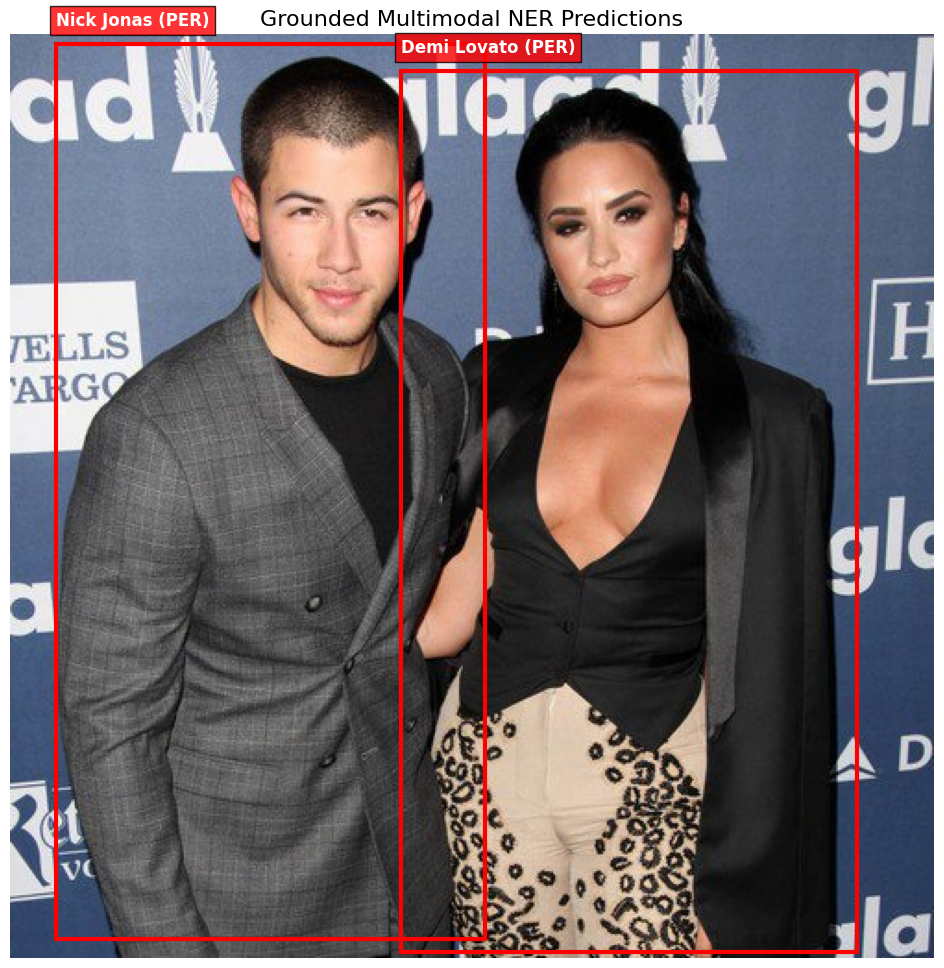

In [77]:
K = 16 # The number of object regions your model was trained with
npz_file_path = "/kaggle/input/twitter10000-vinvl/Twitter10000_VinVL/" + img_id + ".jpg.npz"

data = np.load(npz_file_path)
all_boxes = data['bounding_boxes']
all_features = data['box_features']
all_scores = data['scores']
top_k_indices = np.argsort(all_scores)[-K:][::-1]

candidate_bboxes = all_boxes[top_k_indices] # Shape: (16, 4)
# This is the final image_feature for your model
image_feature = all_features[top_k_indices] # Shape: (16, 2048)

idx_to_token = {
    2: "<groundable>", 5: "PER",
    9: "Nick", 10: "Jonas", 13: "Demi", 15: "Lovato",
}
original_text = ' '.join(batch['raw_words'][0])

image_path = "/kaggle/working/IJCAI2019_data/twitter2017_images/" + img_id + ".jpg"

final_predictions = decode_predictions_with_region_indices(pred, region_pred, candidate_bboxes, idx_to_token)
print(final_predictions)
visualize_results(image_path, original_text, final_predictions)

In [95]:
batch = collate_fn([test_dataset[2]]) 

src_tokens = batch['src_tokens']
image_feature = batch['image_feature']
tgt_tokens = batch['tgt_tokens']
src_seq_len = batch['src_seq_len']
tgt_seq_len = batch['tgt_seq_len']
first = batch['first']
region_label = batch['region_label']


pred, region_pred = model.predict(src_tokens,image_feature, src_seq_len=src_seq_len, first=first)

[{'text': 'Angelina Jolie', 'type': 'PER', 'bbox': array([293.5111  ,  21.955994, 593.0248  , 449.25    ], dtype=float32)}, {'text': 'Donald Trump', 'type': 'PER', 'bbox': None}]
--- Decoded Predictions ---
Original Text: News Update Angelina Jolie slams Donald Trump ' s stance on religious freedom and immigration

  Entity: 'Angelina Jolie', Type: PER, BBox: [293.5111    21.955994 593.0248   449.25    ]
  Entity: 'Donald Trump', Type: PER, BBox: None


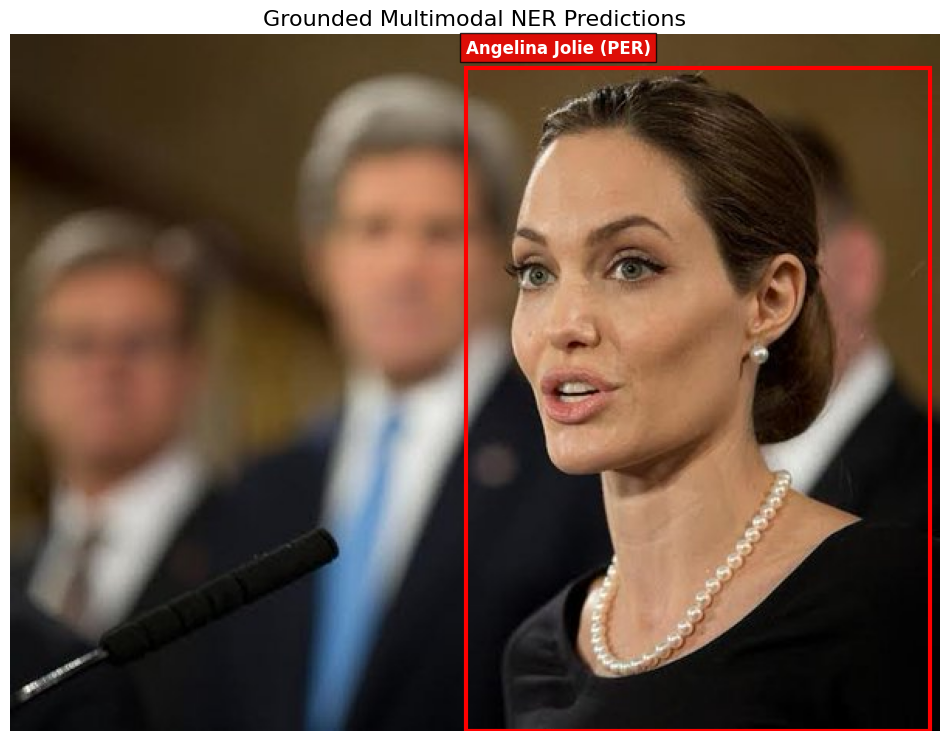

In [97]:
K = 16 # The number of object regions your model was trained with
npz_file_path = "/kaggle/input/twitter10000-vinvl/Twitter10000_VinVL/" + test_img_id + ".jpg.npz"

data = np.load(npz_file_path)
all_boxes = data['bounding_boxes']
all_features = data['box_features']
all_scores = data['scores']
top_k_indices = np.argsort(all_scores)[-K:][::-1]

candidate_bboxes = all_boxes[top_k_indices] # Shape: (16, 4)
# This is the final image_feature for your model
image_feature = all_features[top_k_indices] # Shape: (16, 2048)

idx_to_token = {
    2: "<groundable>", 3: "<ungroundable>", 5: "PER",
    11: "Angelina", 13: "Jolie", 16: "Donald", 17: "Trump",
}
original_text = ' '.join(batch['raw_words'][0])

image_path = "/kaggle/working/IJCAI2019_data/twitter2017_images/" + test_img_id + ".jpg"

final_predictions = decode_predictions_with_region_indices(pred, region_pred, candidate_bboxes, idx_to_token)
print(final_predictions)
visualize_results(image_path, original_text, final_predictions)